In [1]:
import numpy as np

from os import listdir
from os.path import isfile, join
import networkx as nx

import dgl
from dgl.nn import RelGraphConv

import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np


from dgl.nn import GraphConv, AvgPooling
from dgl.nn.pytorch import Sequential

from dgl.dataloading import GraphDataLoader
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler, ConcatDataset
from sklearn.model_selection import train_test_split

from sklearn.model_selection import KFold, StratifiedKFold

import matplotlib.pyplot as plt

from torch.optim import lr_scheduler

import pickle

from copy import deepcopy

In [2]:
pickle_name = 'nx_url_dataset.pickle'
with open(pickle_name, 'rb') as f:
    nx_train_set, nx_test_set = pickle.load(f)

In [3]:
e2id = {'title':0, 
        'link':1,
        'reversed_title':2,
        'reversed_link':3,
        'domain':4
       }

def add_encoding(dataset):
    for j in range(len(dataset)):
        g = dataset[j][0]
        for e in g.edges:
#             print(g.edges[e[0], e[1]]['link_type'])
            if g.edges[e[0], e[1]]['link_type'] == 'title':
                g.edges[e[0], e[1]]['type'] = e2id['title']
                g.add_edge(e[1], e[0])
                g.edges[e[1], e[0]]['type'] = e2id['reversed_title']
            
                
            if g.edges[e[0], e[1]]['link_type'] == 'link':
                g.edges[e[0], e[1]]['type'] = e2id['link']
                g.add_edge(e[1], e[0])
                g.edges[e[1], e[0]]['type'] = e2id['reversed_link']
                
        node_domains = dict()
        for i in range(len(g.nodes)):
            g.nodes[i]['h'] = torch.tensor([0., 0., 0.])
            g.nodes[i]['h'][g.nodes[i]['level']] = 1.
            if g.nodes[i]['domain'] not in node_domains:
                node_domains[g.nodes[i]['domain']] = [i]
            else:
                node_domains[g.nodes[i]['domain']].append(i)
            
        print(node_domains)
        for domain in node_domains:
            if len(node_domains[domain]) >1:
                for d1 in node_domains[domain]:
                    for d2 in node_domains[domain]:
                        if d1 == d2:
                            continue
                        g.add_edge(d1, d2)
                        g.edges[d1, d2]['type'] = e2id['domain']
                        
    return dataset
train_set = add_encoding(nx_train_set)
test_set = add_encoding(nx_test_set)

In [4]:
train_graphs = [(dgl.from_networkx(g, node_attrs=["h"], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in train_set]
train_labels = [l for _, l in train_set]
test_graphs = [(dgl.from_networkx(g, node_attrs=['h'], edge_attrs=['type']), torch.tensor([l]).float()) for g, l in test_set]
test_labels = [l for _, l in test_set]


In [5]:
class RGCN(nn.Module):
    def __init__(self, in_features, hidden_features, dropout, num_edge_types):
        super(RGCN, self).__init__()
        self.in_layer = RelGraphConv(in_features, hidden_features, num_edge_types, activation=nn.ReLU())
        self.dropout1 = nn.Dropout(dropout)
        self.out_layer = RelGraphConv(hidden_features, hidden_features, num_edge_types, activation=nn.ReLU())
        self.dropout2 = nn.Dropout(dropout)
        self.global_mean_pool = dgl.nn.pytorch.glob.AvgPooling()
        
        self.fc = nn.Linear(hidden_features, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, g, in_feat, e_types):
        h = self.in_layer(g, in_feat, e_types)
        h = self.dropout1(h)
        h = self.out_layer(g, h, e_types)
        h = self.dropout2(h)
        h = self.global_mean_pool(g, h)
        h = self.fc(h)
        
        return self.sigmoid(h)

In [6]:
def evaluate(model, dataloader):
    model.eval()
    num_correct = 0
    num_tests = 0
    for batched_graph, labels in dataloader:
        pred = torch.round(model(batched_graph, batched_graph.ndata['h'].float(), batched_graph.edata['type']))
        num_correct += (pred==labels).sum().float().item()
        num_tests += len(labels)
    return num_correct / num_tests

def train(model, train_loader, optimizer):
    Loss = nn.BCELoss()
    
    model.train()
    ret_loss = 0
    n_graphs = 0
    for data, target in train_loader:
        output = model(data, data.ndata['h'].float(), data.edata['type'])
        
        loss = Loss(output, target)
        ret_loss += loss.item()/len(target)
        n_graphs += len(target)     
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        return loss.item()
#     return ret_loss/n_graphs

def val_loss(model, loader):
    Loss = nn.BCELoss()
    model.eval()
    ret_loss = 0
    n_graphs = 0
    with torch.no_grad():
        for data, target in train_loader:
            data, target = data.to(device), target.to(device)
            output = model(data, data.ndata['h'].float(), data.edata['type'])
            loss = Loss(output, target)

            return loss.item()
        


In [7]:
# model.in_layer.linear_r

In [8]:
splits=StratifiedKFold(n_splits=5,shuffle=True,random_state=42)
split_idxs = splits.split(np.arange(len(train_graphs)), train_labels)

num_epochs=100
from itertools import product
hidden_size = [4, 8, 16, 32, 64]
dropout = [0., 0.3, 0.5, 0.7]

lr = [0.1, 0.05, 0.01, 0.005]

tg = dgl.batch([g for g,_ in train_graphs])

model_params = list(product(hidden_size, dropout, lr))

in_feature_size = train_graphs[0][0].ndata['h'].shape[1]
num_edge_types = tg.edata['type'].max().item() +1
print(num_edge_types)

# model_params = [[4, 0., 0.1]]
# print(model_params)

4


In [9]:
# for l in splits.split(np.arange(len(train_graphs)), train_labels):
#     print(train_labels[l])

In [10]:
best_test_acc = 0
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
results = []
for i, (hidden_size, dropout, lr) in enumerate(model_params):
    foldperf = {}
    print(f"model {i}/{len(model_params)}")
    print('Model parameters: hidden_size {}, dropout {}, optimizer lr {}'.format(*model_params[i]))
    
    for fold, (train_idx, val_idx) in enumerate(splits.split(np.arange(len(train_graphs)), train_labels)):
        model = RGCN(in_feature_size, hidden_size, dropout, num_edge_types)

        lrs = []


        train_sampler = SubsetRandomSampler(train_idx)
        test_sampler = SubsetRandomSampler(val_idx)
        train_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=train_sampler)
        test_loader = GraphDataLoader(train_graphs, batch_size=1000, sampler=test_sampler)

        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}

        for epoch in range(num_epochs):
            train_loss = train(model,train_loader, optimizer)
            train_acc = evaluate(model, train_loader)
            test_loss = val_loss(model,test_loader)
            test_acc = evaluate(model, test_loader)
            if epoch%10==1:
                print("{} Loss train/val:{:.3f} / {:.3f} Acc train/val {:.2f} / {:.2f} %".format(epoch, train_loss,
                                                                                              test_loss,
                                                                                              100*train_acc,
                                                                                              100*test_acc))

            history['train_loss'].append(train_loss)
            history['test_loss'].append(test_loss)
            history['train_acc'].append(train_acc)
            history['test_acc'].append(test_acc)
        foldperf[f'fold{fold+1}'] = history  
    results.append(foldperf)
#     break


model 0/80
Model parameters: hidden_size 4, dropout 0.0, optimizer lr 0.1
1 Loss train/val:0.671 / 0.673 Acc train/val 66.03 / 52.50 %


C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.582 / 0.579 Acc train/val 69.87 / 52.50 %
21 Loss train/val:0.568 / 0.565 Acc train/val 70.51 / 57.50 %
31 Loss train/val:0.555 / 0.553 Acc train/val 68.59 / 55.00 %
41 Loss train/val:0.542 / 0.546 Acc train/val 69.23 / 57.50 %
51 Loss train/val:0.531 / 0.528 Acc train/val 69.87 / 57.50 %
61 Loss train/val:0.523 / 0.520 Acc train/val 69.23 / 57.50 %
71 Loss train/val:0.521 / 0.526 Acc train/val 72.44 / 70.00 %
81 Loss train/val:0.514 / 0.509 Acc train/val 70.51 / 57.50 %
91 Loss train/val:0.507 / 0.505 Acc train/val 71.15 / 60.00 %
1 Loss train/val:0.885 / 0.785 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.691 / 0.691 Acc train/val 51.59 / 53.85 %
21 Loss train/val:0.693 / 0.690 Acc train/val 52.87 / 46.15 %
31 Loss train/val:0.668 / 0.665 Acc train/val 60.51 / 48.72 %
41 Loss train/val:0.660 / 0.659 Acc train/val 60.51 / 51.28 %
51 Loss train/val:0.657 / 0.657 Acc train/val 60.51 / 48.72 %
61 Loss train/val:0.656 / 0.656 Acc train/val 60.51 / 48.72 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.593 / 0.592 Acc train/val 66.67 / 62.50 %
21 Loss train/val:0.583 / 0.581 Acc train/val 66.03 / 65.00 %
31 Loss train/val:0.570 / 0.569 Acc train/val 69.87 / 62.50 %
41 Loss train/val:0.557 / 0.555 Acc train/val 69.87 / 65.00 %
51 Loss train/val:0.543 / 0.542 Acc train/val 71.15 / 62.50 %
61 Loss train/val:0.530 / 0.529 Acc train/val 71.79 / 60.00 %
71 Loss train/val:0.521 / 0.521 Acc train/val 71.79 / 60.00 %
81 Loss train/val:0.517 / 0.516 Acc train/val 69.87 / 57.50 %
91 Loss train/val:0.514 / 0.514 Acc train/val 71.79 / 60.00 %
1 Loss train/val:0.832 / 0.688 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.587 / 0.579 Acc train/val 69.43 / 66.67 %
21 Loss train/val:0.561 / 0.564 Acc train/val 67.52 / 66.67 %
31 Loss train/val:0.549 / 0.548 Acc train/val 71.34 / 64.10 %
41 Loss train/val:0.535 / 0.534 Acc train/val 70.70 / 69.23 %
51 Loss train/val:0.523 / 0.522 Acc train/val 71.97 / 66.67 %
61 Loss train/val:0.522 / 0.516 Acc train/val 73.25 / 66.67 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.628 / 0.622 Acc train/val 66.67 / 60.00 %
21 Loss train/val:0.589 / 0.587 Acc train/val 66.67 / 60.00 %
31 Loss train/val:0.571 / 0.570 Acc train/val 66.03 / 62.50 %
41 Loss train/val:0.560 / 0.559 Acc train/val 66.67 / 60.00 %
51 Loss train/val:0.549 / 0.548 Acc train/val 65.38 / 62.50 %
61 Loss train/val:0.539 / 0.538 Acc train/val 69.23 / 62.50 %
71 Loss train/val:0.530 / 0.530 Acc train/val 71.15 / 62.50 %
81 Loss train/val:0.523 / 0.522 Acc train/val 69.87 / 65.00 %
91 Loss train/val:0.515 / 0.515 Acc train/val 71.15 / 65.00 %
1 Loss train/val:0.966 / 0.864 Acc train/val 56.69 / 51.28 %
11 Loss train/val:0.631 / 0.629 Acc train/val 59.24 / 56.41 %
21 Loss train/val:0.580 / 0.578 Acc train/val 68.15 / 66.67 %
31 Loss train/val:0.570 / 0.568 Acc train/val 69.43 / 61.54 %
41 Loss train/val:0.562 / 0.561 Acc train/val 69.43 / 61.54 %
51 Loss train/val:0.558 / 0.558 Acc train/val 69.43 / 61.54 %
61 Loss train/val:0.555 / 0.555 Acc train/val 70.06 / 61.54 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.688 / 0.683 Acc train/val 49.36 / 45.00 %
21 Loss train/val:0.648 / 0.645 Acc train/val 55.13 / 42.50 %
31 Loss train/val:0.629 / 0.628 Acc train/val 64.10 / 50.00 %
41 Loss train/val:0.618 / 0.617 Acc train/val 66.67 / 57.50 %
51 Loss train/val:0.611 / 0.610 Acc train/val 67.31 / 57.50 %
61 Loss train/val:0.602 / 0.601 Acc train/val 68.59 / 55.00 %
71 Loss train/val:0.591 / 0.590 Acc train/val 67.31 / 57.50 %
81 Loss train/val:0.582 / 0.581 Acc train/val 67.95 / 57.50 %
91 Loss train/val:0.577 / 0.577 Acc train/val 66.67 / 57.50 %
1 Loss train/val:0.883 / 0.862 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.728 / 0.718 Acc train/val 49.68 / 53.85 %
21 Loss train/val:0.669 / 0.666 Acc train/val 52.87 / 53.85 %
31 Loss train/val:0.640 / 0.638 Acc train/val 59.87 / 58.97 %
41 Loss train/val:0.624 / 0.622 Acc train/val 62.42 / 61.54 %
51 Loss train/val:0.610 / 0.609 Acc train/val 65.61 / 71.79 %
61 Loss train/val:0.600 / 0.600 Acc train/val 66.88 / 71.79 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.877 / 0.844 Acc train/val 54.49 / 65.00 %
11 Loss train/val:0.669 / 0.657 Acc train/val 60.90 / 52.50 %
21 Loss train/val:0.653 / 0.654 Acc train/val 65.38 / 62.50 %
31 Loss train/val:0.657 / 0.652 Acc train/val 60.26 / 47.50 %
41 Loss train/val:0.642 / 0.647 Acc train/val 60.26 / 50.00 %
51 Loss train/val:0.648 / 0.645 Acc train/val 62.82 / 45.00 %
61 Loss train/val:0.629 / 0.631 Acc train/val 62.82 / 52.50 %
71 Loss train/val:0.625 / 0.621 Acc train/val 60.90 / 52.50 %
81 Loss train/val:0.618 / 0.613 Acc train/val 64.74 / 60.00 %
91 Loss train/val:0.624 / 0.604 Acc train/val 67.31 / 50.00 %
1 Loss train/val:0.933 / 0.708 Acc train/val 49.68 / 48.72 %
11 Loss train/val:0.700 / 0.693 Acc train/val 52.23 / 51.28 %
21 Loss train/val:0.681 / 0.674 Acc train/val 57.32 / 56.41 %
31 Loss train/val:0.679 / 0.642 Acc train/val 62.42 / 58.97 %
41 Loss train/val:0.668 / 0.652 Acc train/val 59.87 / 51.28 %
51 Loss train/val:0.648 / 0.635 Acc train/val 66.24 / 53.85 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.642 / 0.619 Acc train/val 62.18 / 50.00 %
21 Loss train/val:0.575 / 0.578 Acc train/val 67.31 / 55.00 %
31 Loss train/val:0.616 / 0.598 Acc train/val 66.67 / 52.50 %
41 Loss train/val:0.597 / 0.581 Acc train/val 67.31 / 55.00 %
51 Loss train/val:0.608 / 0.567 Acc train/val 67.95 / 52.50 %
61 Loss train/val:0.594 / 0.582 Acc train/val 66.67 / 52.50 %
71 Loss train/val:0.580 / 0.557 Acc train/val 68.59 / 62.50 %
81 Loss train/val:0.587 / 0.559 Acc train/val 70.51 / 57.50 %
91 Loss train/val:0.596 / 0.564 Acc train/val 66.67 / 52.50 %
1 Loss train/val:0.789 / 0.732 Acc train/val 43.95 / 53.85 %
11 Loss train/val:0.640 / 0.636 Acc train/val 66.24 / 64.10 %
21 Loss train/val:0.639 / 0.629 Acc train/val 68.79 / 64.10 %
31 Loss train/val:0.644 / 0.616 Acc train/val 64.33 / 56.41 %
41 Loss train/val:0.640 / 0.615 Acc train/val 63.69 / 56.41 %
51 Loss train/val:0.606 / 0.600 Acc train/val 66.24 / 61.54 %
61 Loss train/val:0.617 / 0.605 Acc train/val 64.97 / 56.41 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:3.031 / 1.824 Acc train/val 48.72 / 47.50 %
11 Loss train/val:0.860 / 0.740 Acc train/val 42.95 / 37.50 %
21 Loss train/val:0.725 / 0.710 Acc train/val 51.92 / 52.50 %
31 Loss train/val:0.692 / 0.699 Acc train/val 51.92 / 52.50 %
41 Loss train/val:0.675 / 0.680 Acc train/val 51.92 / 52.50 %
51 Loss train/val:0.652 / 0.660 Acc train/val 54.49 / 42.50 %
61 Loss train/val:0.650 / 0.641 Acc train/val 60.90 / 47.50 %
71 Loss train/val:0.633 / 0.627 Acc train/val 69.87 / 52.50 %
81 Loss train/val:0.632 / 0.623 Acc train/val 68.59 / 55.00 %
91 Loss train/val:0.614 / 0.618 Acc train/val 68.59 / 55.00 %
1 Loss train/val:2.554 / 1.975 Acc train/val 48.41 / 46.15 %
11 Loss train/val:0.915 / 0.799 Acc train/val 48.41 / 46.15 %
21 Loss train/val:0.723 / 0.709 Acc train/val 48.41 / 46.15 %
31 Loss train/val:0.685 / 0.694 Acc train/val 49.04 / 46.15 %
41 Loss train/val:0.687 / 0.683 Acc train/val 56.69 / 51.28 %
51 Loss train/val:0.675 / 0.672 Acc train/val 62.42 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:1.244 / 0.971 Acc train/val 53.85 / 60.00 %
21 Loss train/val:0.821 / 0.807 Acc train/val 52.56 / 65.00 %
31 Loss train/val:0.736 / 0.662 Acc train/val 61.54 / 62.50 %
41 Loss train/val:0.684 / 0.651 Acc train/val 66.67 / 65.00 %
51 Loss train/val:0.684 / 0.622 Acc train/val 69.23 / 62.50 %
61 Loss train/val:0.693 / 0.618 Acc train/val 73.08 / 70.00 %
71 Loss train/val:0.600 / 0.624 Acc train/val 71.79 / 60.00 %
81 Loss train/val:0.646 / 0.613 Acc train/val 70.51 / 67.50 %
91 Loss train/val:0.655 / 0.611 Acc train/val 70.51 / 67.50 %
1 Loss train/val:1.231 / 1.171 Acc train/val 48.41 / 46.15 %
11 Loss train/val:0.910 / 0.845 Acc train/val 48.41 / 46.15 %
21 Loss train/val:0.731 / 0.709 Acc train/val 50.96 / 51.28 %
31 Loss train/val:0.680 / 0.676 Acc train/val 54.14 / 51.28 %
41 Loss train/val:0.653 / 0.667 Acc train/val 57.32 / 53.85 %
51 Loss train/val:0.675 / 0.657 Acc train/val 63.06 / 58.97 %
61 Loss train/val:0.670 / 0.648 Acc train/val 64.97 / 58.97 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.659 / 0.624 Acc train/val 69.23 / 70.00 %
21 Loss train/val:0.630 / 0.624 Acc train/val 66.67 / 60.00 %
31 Loss train/val:0.609 / 0.591 Acc train/val 69.87 / 55.00 %
41 Loss train/val:0.601 / 0.594 Acc train/val 69.23 / 55.00 %
51 Loss train/val:0.615 / 0.604 Acc train/val 66.03 / 55.00 %
61 Loss train/val:0.628 / 0.594 Acc train/val 66.03 / 57.50 %
71 Loss train/val:0.596 / 0.587 Acc train/val 70.51 / 60.00 %
81 Loss train/val:0.638 / 0.600 Acc train/val 64.10 / 57.50 %
91 Loss train/val:0.621 / 0.608 Acc train/val 63.46 / 52.50 %
1 Loss train/val:0.712 / 0.701 Acc train/val 54.14 / 53.85 %
11 Loss train/val:0.666 / 0.699 Acc train/val 50.32 / 46.15 %
21 Loss train/val:0.682 / 0.665 Acc train/val 64.97 / 53.85 %
31 Loss train/val:0.659 / 0.656 Acc train/val 59.24 / 48.72 %
41 Loss train/val:0.662 / 0.653 Acc train/val 64.33 / 53.85 %
51 Loss train/val:0.652 / 0.659 Acc train/val 60.51 / 61.54 %
61 Loss train/val:0.659 / 0.659 Acc train/val 62.42 / 61.54 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.671 / 0.678 Acc train/val 55.77 / 60.00 %
21 Loss train/val:0.668 / 0.635 Acc train/val 66.03 / 60.00 %
31 Loss train/val:0.618 / 0.648 Acc train/val 66.67 / 62.50 %
41 Loss train/val:0.618 / 0.626 Acc train/val 71.79 / 62.50 %
51 Loss train/val:0.612 / 0.628 Acc train/val 69.87 / 60.00 %
61 Loss train/val:0.616 / 0.628 Acc train/val 67.95 / 60.00 %
71 Loss train/val:0.617 / 0.625 Acc train/val 67.95 / 62.50 %
81 Loss train/val:0.607 / 0.611 Acc train/val 72.44 / 62.50 %
91 Loss train/val:0.599 / 0.629 Acc train/val 67.31 / 60.00 %
1 Loss train/val:0.721 / 0.689 Acc train/val 56.69 / 51.28 %
11 Loss train/val:0.676 / 0.669 Acc train/val 61.78 / 53.85 %
21 Loss train/val:0.684 / 0.658 Acc train/val 59.87 / 48.72 %
31 Loss train/val:0.655 / 0.650 Acc train/val 63.06 / 51.28 %
41 Loss train/val:0.696 / 0.648 Acc train/val 67.52 / 56.41 %
51 Loss train/val:0.627 / 0.624 Acc train/val 69.43 / 61.54 %
61 Loss train/val:0.633 / 0.644 Acc train/val 64.33 / 64.10 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.021 / 0.806 Acc train/val 51.92 / 55.00 %
11 Loss train/val:0.679 / 0.625 Acc train/val 60.90 / 50.00 %
21 Loss train/val:0.646 / 0.635 Acc train/val 68.59 / 55.00 %
31 Loss train/val:0.621 / 0.613 Acc train/val 69.23 / 57.50 %
41 Loss train/val:0.646 / 0.616 Acc train/val 69.23 / 55.00 %
51 Loss train/val:0.633 / 0.614 Acc train/val 67.31 / 55.00 %
61 Loss train/val:0.643 / 0.615 Acc train/val 64.74 / 57.50 %
71 Loss train/val:0.642 / 0.609 Acc train/val 67.95 / 57.50 %
81 Loss train/val:0.633 / 0.610 Acc train/val 67.31 / 65.00 %
91 Loss train/val:0.620 / 0.611 Acc train/val 66.67 / 65.00 %
1 Loss train/val:1.162 / 1.086 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.756 / 0.705 Acc train/val 51.59 / 53.85 %
21 Loss train/val:0.650 / 0.629 Acc train/val 64.33 / 61.54 %
31 Loss train/val:0.664 / 0.612 Acc train/val 68.15 / 61.54 %
41 Loss train/val:0.655 / 0.604 Acc train/val 65.61 / 64.10 %
51 Loss train/val:0.601 / 0.595 Acc train/val 70.06 / 66.67 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.495 / 1.487 Acc train/val 44.87 / 57.50 %
11 Loss train/val:1.069 / 0.848 Acc train/val 39.74 / 50.00 %
21 Loss train/val:0.868 / 0.657 Acc train/val 51.92 / 50.00 %
31 Loss train/val:0.774 / 0.647 Acc train/val 58.97 / 45.00 %
41 Loss train/val:0.685 / 0.643 Acc train/val 67.31 / 50.00 %
51 Loss train/val:0.653 / 0.641 Acc train/val 67.31 / 55.00 %
61 Loss train/val:0.683 / 0.632 Acc train/val 67.31 / 55.00 %
71 Loss train/val:0.676 / 0.622 Acc train/val 67.31 / 55.00 %
81 Loss train/val:0.635 / 0.616 Acc train/val 67.31 / 55.00 %
91 Loss train/val:0.639 / 0.618 Acc train/val 69.87 / 55.00 %
1 Loss train/val:0.961 / 0.713 Acc train/val 49.68 / 48.72 %
11 Loss train/val:0.738 / 0.716 Acc train/val 65.61 / 56.41 %
21 Loss train/val:0.713 / 0.660 Acc train/val 64.97 / 61.54 %
31 Loss train/val:0.629 / 0.622 Acc train/val 66.24 / 61.54 %
41 Loss train/val:0.691 / 0.616 Acc train/val 66.24 / 61.54 %
51 Loss train/val:0.648 / 0.612 Acc train/val 68.79 / 69.23 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.670 / 0.644 Acc train/val 64.74 / 50.00 %
21 Loss train/val:0.685 / 0.669 Acc train/val 63.46 / 57.50 %
31 Loss train/val:0.688 / 0.667 Acc train/val 51.92 / 52.50 %
41 Loss train/val:0.676 / 0.658 Acc train/val 59.62 / 50.00 %
51 Loss train/val:0.675 / 0.665 Acc train/val 61.54 / 52.50 %
61 Loss train/val:0.673 / 0.682 Acc train/val 58.97 / 50.00 %
71 Loss train/val:0.685 / 0.659 Acc train/val 60.26 / 52.50 %
81 Loss train/val:0.679 / 0.665 Acc train/val 62.18 / 47.50 %
91 Loss train/val:0.670 / 0.669 Acc train/val 51.92 / 52.50 %
1 Loss train/val:0.885 / 0.706 Acc train/val 52.23 / 53.85 %
11 Loss train/val:0.677 / 0.679 Acc train/val 56.05 / 53.85 %
21 Loss train/val:0.749 / 0.671 Acc train/val 59.24 / 56.41 %
31 Loss train/val:0.659 / 0.669 Acc train/val 64.33 / 58.97 %
41 Loss train/val:0.664 / 0.691 Acc train/val 49.04 / 48.72 %
51 Loss train/val:0.664 / 0.691 Acc train/val 49.68 / 48.72 %
61 Loss train/val:0.669 / 0.677 Acc train/val 60.51 / 58.97 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.717 / 0.689 Acc train/val 51.92 / 50.00 %
21 Loss train/val:0.710 / 0.656 Acc train/val 62.82 / 65.00 %
31 Loss train/val:0.655 / 0.663 Acc train/val 66.03 / 60.00 %
41 Loss train/val:0.680 / 0.652 Acc train/val 65.38 / 60.00 %
51 Loss train/val:0.673 / 0.655 Acc train/val 66.67 / 60.00 %
61 Loss train/val:0.680 / 0.675 Acc train/val 58.33 / 62.50 %
71 Loss train/val:0.650 / 0.642 Acc train/val 67.31 / 65.00 %
81 Loss train/val:0.694 / 0.642 Acc train/val 65.38 / 62.50 %
91 Loss train/val:0.667 / 0.644 Acc train/val 69.23 / 57.50 %
1 Loss train/val:0.686 / 0.663 Acc train/val 59.87 / 48.72 %
11 Loss train/val:0.673 / 0.670 Acc train/val 60.51 / 48.72 %
21 Loss train/val:0.675 / 0.656 Acc train/val 63.69 / 48.72 %
31 Loss train/val:0.662 / 0.654 Acc train/val 61.15 / 48.72 %
41 Loss train/val:0.644 / 0.655 Acc train/val 64.33 / 51.28 %
51 Loss train/val:0.655 / 0.637 Acc train/val 67.52 / 56.41 %
61 Loss train/val:0.624 / 0.614 Acc train/val 68.15 / 58.97 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:1.063 / 0.622 Acc train/val 66.67 / 70.00 %
21 Loss train/val:0.772 / 0.724 Acc train/val 53.21 / 55.00 %
31 Loss train/val:0.712 / 0.631 Acc train/val 61.54 / 57.50 %
41 Loss train/val:0.676 / 0.625 Acc train/val 64.10 / 67.50 %
51 Loss train/val:0.668 / 0.637 Acc train/val 63.46 / 57.50 %
61 Loss train/val:0.665 / 0.643 Acc train/val 64.10 / 57.50 %
71 Loss train/val:0.665 / 0.644 Acc train/val 62.82 / 60.00 %
81 Loss train/val:0.652 / 0.643 Acc train/val 63.46 / 60.00 %
91 Loss train/val:0.637 / 0.642 Acc train/val 62.82 / 57.50 %
1 Loss train/val:0.847 / 0.816 Acc train/val 52.87 / 58.97 %
11 Loss train/val:0.840 / 0.663 Acc train/val 66.88 / 71.79 %
21 Loss train/val:0.689 / 0.638 Acc train/val 68.79 / 61.54 %
31 Loss train/val:0.685 / 0.643 Acc train/val 63.69 / 61.54 %
41 Loss train/val:0.662 / 0.645 Acc train/val 64.33 / 58.97 %
51 Loss train/val:0.669 / 0.641 Acc train/val 66.24 / 56.41 %
61 Loss train/val:0.646 / 0.638 Acc train/val 64.97 / 51.28 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.413 / 1.509 Acc train/val 43.59 / 47.50 %
11 Loss train/val:1.155 / 0.839 Acc train/val 40.38 / 50.00 %
21 Loss train/val:0.939 / 0.677 Acc train/val 51.92 / 47.50 %
31 Loss train/val:0.796 / 0.665 Acc train/val 51.92 / 52.50 %
41 Loss train/val:0.738 / 0.654 Acc train/val 59.62 / 52.50 %
51 Loss train/val:0.691 / 0.649 Acc train/val 57.05 / 42.50 %
61 Loss train/val:0.711 / 0.649 Acc train/val 57.05 / 42.50 %
71 Loss train/val:0.708 / 0.649 Acc train/val 57.05 / 42.50 %
81 Loss train/val:0.653 / 0.650 Acc train/val 58.97 / 47.50 %
91 Loss train/val:0.689 / 0.650 Acc train/val 61.54 / 47.50 %
1 Loss train/val:8.584 / 3.008 Acc train/val 48.41 / 46.15 %
11 Loss train/val:3.608 / 1.574 Acc train/val 48.41 / 46.15 %
21 Loss train/val:1.987 / 0.892 Acc train/val 48.41 / 46.15 %
31 Loss train/val:1.094 / 0.715 Acc train/val 45.86 / 46.15 %
41 Loss train/val:0.775 / 0.695 Acc train/val 47.77 / 51.28 %
51 Loss train/val:0.726 / 0.693 Acc train/val 51.59 / 51.28 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.012 / 0.840 Acc train/val 53.21 / 57.50 %
11 Loss train/val:0.632 / 0.622 Acc train/val 65.38 / 50.00 %
21 Loss train/val:0.552 / 0.554 Acc train/val 68.59 / 67.50 %
31 Loss train/val:0.525 / 0.526 Acc train/val 69.87 / 67.50 %
41 Loss train/val:0.502 / 0.500 Acc train/val 74.36 / 67.50 %
51 Loss train/val:0.483 / 0.484 Acc train/val 73.08 / 62.50 %
61 Loss train/val:0.466 / 0.466 Acc train/val 71.79 / 62.50 %
71 Loss train/val:0.456 / 0.455 Acc train/val 75.64 / 62.50 %
81 Loss train/val:0.448 / 0.446 Acc train/val 76.28 / 62.50 %
91 Loss train/val:0.441 / 0.443 Acc train/val 76.28 / 67.50 %
1 Loss train/val:2.079 / 0.752 Acc train/val 59.87 / 64.10 %
11 Loss train/val:0.628 / 0.623 Acc train/val 65.61 / 64.10 %
21 Loss train/val:0.592 / 0.591 Acc train/val 67.52 / 66.67 %
31 Loss train/val:0.576 / 0.575 Acc train/val 69.43 / 66.67 %
41 Loss train/val:0.569 / 0.569 Acc train/val 66.24 / 64.10 %
51 Loss train/val:0.564 / 0.564 Acc train/val 67.52 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.733 / 0.648 Acc train/val 60.90 / 50.00 %
11 Loss train/val:0.590 / 0.571 Acc train/val 67.95 / 65.00 %
21 Loss train/val:0.556 / 0.553 Acc train/val 69.87 / 60.00 %
31 Loss train/val:0.541 / 0.540 Acc train/val 68.59 / 60.00 %
41 Loss train/val:0.523 / 0.521 Acc train/val 67.95 / 60.00 %
51 Loss train/val:0.502 / 0.500 Acc train/val 69.23 / 65.00 %
61 Loss train/val:0.490 / 0.492 Acc train/val 71.79 / 65.00 %
71 Loss train/val:0.466 / 0.463 Acc train/val 76.28 / 65.00 %
81 Loss train/val:0.460 / 0.458 Acc train/val 75.64 / 65.00 %
91 Loss train/val:0.448 / 0.456 Acc train/val 75.00 / 67.50 %
1 Loss train/val:0.824 / 0.900 Acc train/val 55.41 / 56.41 %
11 Loss train/val:0.608 / 0.608 Acc train/val 66.88 / 58.97 %
21 Loss train/val:0.581 / 0.579 Acc train/val 70.06 / 69.23 %
31 Loss train/val:0.568 / 0.566 Acc train/val 70.06 / 74.36 %
41 Loss train/val:0.556 / 0.556 Acc train/val 70.70 / 69.23 %
51 Loss train/val:0.550 / 0.549 Acc train/val 70.70 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.130 / 0.981 Acc train/val 60.26 / 60.00 %
11 Loss train/val:0.607 / 0.603 Acc train/val 69.23 / 55.00 %
21 Loss train/val:0.580 / 0.578 Acc train/val 67.31 / 57.50 %
31 Loss train/val:0.562 / 0.561 Acc train/val 70.51 / 62.50 %
41 Loss train/val:0.547 / 0.545 Acc train/val 69.23 / 65.00 %
51 Loss train/val:0.530 / 0.529 Acc train/val 68.59 / 62.50 %
61 Loss train/val:0.515 / 0.516 Acc train/val 71.79 / 65.00 %
71 Loss train/val:0.509 / 0.507 Acc train/val 72.44 / 65.00 %
81 Loss train/val:0.500 / 0.499 Acc train/val 73.72 / 67.50 %
91 Loss train/val:0.493 / 0.492 Acc train/val 73.72 / 67.50 %
1 Loss train/val:1.280 / 1.083 Acc train/val 36.31 / 41.03 %
11 Loss train/val:0.744 / 0.736 Acc train/val 51.59 / 53.85 %
21 Loss train/val:0.659 / 0.657 Acc train/val 49.04 / 48.72 %
31 Loss train/val:0.636 / 0.631 Acc train/val 65.61 / 56.41 %
41 Loss train/val:0.595 / 0.592 Acc train/val 67.52 / 64.10 %
51 Loss train/val:0.572 / 0.569 Acc train/val 73.25 / 74.36 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.793 / 0.738 Acc train/val 56.41 / 47.50 %
11 Loss train/val:0.650 / 0.643 Acc train/val 57.05 / 55.00 %
21 Loss train/val:0.614 / 0.612 Acc train/val 66.03 / 50.00 %
31 Loss train/val:0.593 / 0.591 Acc train/val 69.23 / 57.50 %
41 Loss train/val:0.579 / 0.578 Acc train/val 69.87 / 57.50 %
51 Loss train/val:0.567 / 0.566 Acc train/val 67.95 / 62.50 %
61 Loss train/val:0.556 / 0.555 Acc train/val 69.87 / 65.00 %
71 Loss train/val:0.547 / 0.546 Acc train/val 69.87 / 65.00 %
81 Loss train/val:0.538 / 0.537 Acc train/val 69.87 / 65.00 %
91 Loss train/val:0.530 / 0.529 Acc train/val 70.51 / 67.50 %
1 Loss train/val:0.976 / 0.922 Acc train/val 50.32 / 53.85 %
11 Loss train/val:0.684 / 0.671 Acc train/val 57.96 / 58.97 %
21 Loss train/val:0.605 / 0.601 Acc train/val 70.06 / 64.10 %
31 Loss train/val:0.577 / 0.574 Acc train/val 70.06 / 66.67 %
41 Loss train/val:0.564 / 0.563 Acc train/val 67.52 / 64.10 %
51 Loss train/val:0.554 / 0.553 Acc train/val 68.79 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.198 / 0.882 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.696 / 0.653 Acc train/val 60.26 / 52.50 %
21 Loss train/val:0.658 / 0.649 Acc train/val 60.26 / 47.50 %
31 Loss train/val:0.679 / 0.659 Acc train/val 59.62 / 45.00 %
41 Loss train/val:0.669 / 0.651 Acc train/val 60.90 / 50.00 %
51 Loss train/val:0.664 / 0.648 Acc train/val 60.90 / 50.00 %
61 Loss train/val:0.666 / 0.649 Acc train/val 61.54 / 50.00 %
71 Loss train/val:0.657 / 0.650 Acc train/val 60.26 / 50.00 %
81 Loss train/val:0.676 / 0.647 Acc train/val 61.54 / 50.00 %
91 Loss train/val:0.661 / 0.647 Acc train/val 60.90 / 50.00 %
1 Loss train/val:2.186 / 1.449 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.670 / 0.655 Acc train/val 59.24 / 48.72 %
21 Loss train/val:0.665 / 0.658 Acc train/val 59.24 / 51.28 %
31 Loss train/val:0.668 / 0.657 Acc train/val 57.32 / 53.85 %
41 Loss train/val:0.664 / 0.649 Acc train/val 58.60 / 53.85 %
51 Loss train/val:0.646 / 0.693 Acc train/val 64.97 / 56.41 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.060 / 0.750 Acc train/val 48.72 / 62.50 %
11 Loss train/val:0.625 / 0.613 Acc train/val 69.23 / 50.00 %
21 Loss train/val:0.624 / 0.612 Acc train/val 69.23 / 55.00 %
31 Loss train/val:0.586 / 0.588 Acc train/val 69.87 / 60.00 %
41 Loss train/val:0.602 / 0.581 Acc train/val 69.87 / 52.50 %
51 Loss train/val:0.603 / 0.575 Acc train/val 69.23 / 62.50 %
61 Loss train/val:0.591 / 0.569 Acc train/val 68.59 / 55.00 %
71 Loss train/val:0.607 / 0.567 Acc train/val 69.87 / 55.00 %
81 Loss train/val:0.587 / 0.563 Acc train/val 66.03 / 52.50 %
91 Loss train/val:0.601 / 0.551 Acc train/val 68.59 / 57.50 %
1 Loss train/val:1.781 / 1.151 Acc train/val 56.69 / 58.97 %
11 Loss train/val:0.613 / 0.630 Acc train/val 63.06 / 58.97 %
21 Loss train/val:0.641 / 0.584 Acc train/val 68.15 / 64.10 %
31 Loss train/val:0.595 / 0.585 Acc train/val 66.88 / 58.97 %
41 Loss train/val:0.600 / 0.575 Acc train/val 66.24 / 64.10 %
51 Loss train/val:0.581 / 0.569 Acc train/val 66.24 / 69.23 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.641 / 0.612 Acc train/val 66.03 / 57.50 %
11 Loss train/val:0.631 / 0.610 Acc train/val 65.38 / 62.50 %
21 Loss train/val:0.619 / 0.582 Acc train/val 68.59 / 52.50 %
31 Loss train/val:0.597 / 0.581 Acc train/val 72.44 / 67.50 %
41 Loss train/val:0.589 / 0.561 Acc train/val 68.59 / 60.00 %
51 Loss train/val:0.555 / 0.552 Acc train/val 67.95 / 62.50 %
61 Loss train/val:0.562 / 0.549 Acc train/val 69.87 / 62.50 %
71 Loss train/val:0.544 / 0.541 Acc train/val 72.44 / 62.50 %
81 Loss train/val:0.588 / 0.529 Acc train/val 73.08 / 62.50 %
91 Loss train/val:0.536 / 0.523 Acc train/val 73.08 / 62.50 %
1 Loss train/val:1.285 / 0.964 Acc train/val 57.96 / 58.97 %
11 Loss train/val:0.714 / 0.678 Acc train/val 63.06 / 58.97 %
21 Loss train/val:0.666 / 0.602 Acc train/val 64.97 / 61.54 %
31 Loss train/val:0.634 / 0.591 Acc train/val 68.15 / 64.10 %
41 Loss train/val:0.625 / 0.582 Acc train/val 70.06 / 64.10 %
51 Loss train/val:0.583 / 0.575 Acc train/val 68.15 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.678 / 0.639 Acc train/val 58.33 / 60.00 %
11 Loss train/val:0.629 / 0.608 Acc train/val 66.67 / 70.00 %
21 Loss train/val:0.650 / 0.586 Acc train/val 66.67 / 57.50 %
31 Loss train/val:0.626 / 0.578 Acc train/val 67.31 / 67.50 %
41 Loss train/val:0.585 / 0.576 Acc train/val 66.67 / 57.50 %
51 Loss train/val:0.582 / 0.574 Acc train/val 69.23 / 57.50 %
61 Loss train/val:0.618 / 0.569 Acc train/val 69.23 / 65.00 %
71 Loss train/val:0.611 / 0.568 Acc train/val 69.87 / 55.00 %
81 Loss train/val:0.601 / 0.566 Acc train/val 70.51 / 60.00 %
91 Loss train/val:0.579 / 0.563 Acc train/val 69.23 / 50.00 %
1 Loss train/val:2.984 / 2.458 Acc train/val 48.41 / 46.15 %
11 Loss train/val:1.005 / 0.854 Acc train/val 45.86 / 48.72 %
21 Loss train/val:0.715 / 0.703 Acc train/val 50.96 / 51.28 %
31 Loss train/val:0.684 / 0.688 Acc train/val 51.59 / 53.85 %
41 Loss train/val:0.647 / 0.633 Acc train/val 61.78 / 61.54 %
51 Loss train/val:0.627 / 0.622 Acc train/val 61.78 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.867 / 1.625 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.660 / 0.650 Acc train/val 60.26 / 50.00 %
21 Loss train/val:0.674 / 0.664 Acc train/val 61.54 / 52.50 %
31 Loss train/val:0.637 / 0.629 Acc train/val 69.23 / 55.00 %
41 Loss train/val:0.657 / 0.626 Acc train/val 64.74 / 55.00 %
51 Loss train/val:0.621 / 0.608 Acc train/val 66.03 / 57.50 %
61 Loss train/val:0.639 / 0.608 Acc train/val 65.38 / 60.00 %
71 Loss train/val:0.641 / 0.610 Acc train/val 68.59 / 47.50 %
81 Loss train/val:0.641 / 0.614 Acc train/val 63.46 / 55.00 %
91 Loss train/val:0.658 / 0.598 Acc train/val 66.03 / 55.00 %
1 Loss train/val:1.030 / 0.980 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.702 / 0.701 Acc train/val 48.41 / 46.15 %
21 Loss train/val:0.692 / 0.693 Acc train/val 51.59 / 53.85 %
31 Loss train/val:0.693 / 0.693 Acc train/val 51.59 / 53.85 %
41 Loss train/val:0.693 / 0.693 Acc train/val 51.59 / 53.85 %
51 Loss train/val:0.693 / 0.693 Acc train/val 51.59 / 53.85 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.325 / 0.781 Acc train/val 41.67 / 50.00 %
11 Loss train/val:0.657 / 0.665 Acc train/val 51.92 / 52.50 %
21 Loss train/val:0.636 / 0.632 Acc train/val 62.18 / 50.00 %
31 Loss train/val:0.635 / 0.617 Acc train/val 62.82 / 52.50 %
41 Loss train/val:0.642 / 0.612 Acc train/val 63.46 / 55.00 %
51 Loss train/val:0.594 / 0.615 Acc train/val 62.18 / 55.00 %
61 Loss train/val:0.633 / 0.613 Acc train/val 61.54 / 52.50 %
71 Loss train/val:0.567 / 0.608 Acc train/val 62.82 / 52.50 %
81 Loss train/val:0.596 / 0.607 Acc train/val 64.10 / 57.50 %
91 Loss train/val:0.602 / 0.594 Acc train/val 66.03 / 60.00 %
1 Loss train/val:0.799 / 0.857 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.652 / 0.650 Acc train/val 57.96 / 53.85 %
21 Loss train/val:0.625 / 0.617 Acc train/val 62.42 / 53.85 %
31 Loss train/val:0.668 / 0.603 Acc train/val 64.33 / 61.54 %
41 Loss train/val:0.605 / 0.600 Acc train/val 64.33 / 61.54 %
51 Loss train/val:0.618 / 0.621 Acc train/val 61.78 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:3.170 / 1.148 Acc train/val 37.82 / 35.00 %
11 Loss train/val:0.838 / 0.722 Acc train/val 51.92 / 52.50 %
21 Loss train/val:0.653 / 0.676 Acc train/val 49.36 / 40.00 %
31 Loss train/val:0.666 / 0.669 Acc train/val 58.97 / 45.00 %
41 Loss train/val:0.647 / 0.641 Acc train/val 62.18 / 45.00 %
51 Loss train/val:0.583 / 0.607 Acc train/val 66.03 / 60.00 %
61 Loss train/val:0.611 / 0.590 Acc train/val 69.23 / 60.00 %
71 Loss train/val:0.620 / 0.590 Acc train/val 66.67 / 57.50 %
81 Loss train/val:0.610 / 0.579 Acc train/val 64.10 / 57.50 %
91 Loss train/val:0.578 / 0.570 Acc train/val 64.74 / 65.00 %
1 Loss train/val:0.969 / 0.685 Acc train/val 48.41 / 48.72 %
11 Loss train/val:0.764 / 0.658 Acc train/val 51.59 / 53.85 %
21 Loss train/val:0.619 / 0.628 Acc train/val 63.06 / 56.41 %
31 Loss train/val:0.606 / 0.604 Acc train/val 63.06 / 61.54 %
41 Loss train/val:0.590 / 0.588 Acc train/val 65.61 / 56.41 %
51 Loss train/val:0.602 / 0.579 Acc train/val 66.24 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.046 / 0.705 Acc train/val 50.64 / 62.50 %
11 Loss train/val:0.685 / 0.650 Acc train/val 52.56 / 50.00 %
21 Loss train/val:0.665 / 0.633 Acc train/val 64.74 / 55.00 %
31 Loss train/val:0.644 / 0.629 Acc train/val 66.67 / 60.00 %
41 Loss train/val:0.628 / 0.617 Acc train/val 67.31 / 57.50 %
51 Loss train/val:0.632 / 0.615 Acc train/val 67.95 / 55.00 %
61 Loss train/val:0.641 / 0.611 Acc train/val 69.23 / 52.50 %
71 Loss train/val:0.619 / 0.603 Acc train/val 67.31 / 52.50 %
81 Loss train/val:0.636 / 0.604 Acc train/val 67.31 / 52.50 %
91 Loss train/val:0.641 / 0.597 Acc train/val 68.59 / 52.50 %
1 Loss train/val:1.399 / 0.941 Acc train/val 43.95 / 38.46 %
11 Loss train/val:0.776 / 0.673 Acc train/val 51.59 / 53.85 %
21 Loss train/val:0.676 / 0.687 Acc train/val 63.06 / 66.67 %
31 Loss train/val:0.774 / 0.611 Acc train/val 63.69 / 58.97 %
41 Loss train/val:0.662 / 0.635 Acc train/val 67.52 / 74.36 %
51 Loss train/val:0.629 / 0.597 Acc train/val 64.33 / 66.67 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.014 / 0.640 Acc train/val 62.82 / 52.50 %
11 Loss train/val:0.652 / 0.653 Acc train/val 58.33 / 57.50 %
21 Loss train/val:0.657 / 0.635 Acc train/val 62.82 / 52.50 %
31 Loss train/val:0.670 / 0.634 Acc train/val 64.10 / 55.00 %
41 Loss train/val:0.657 / 0.662 Acc train/val 58.33 / 55.00 %
51 Loss train/val:0.681 / 0.637 Acc train/val 64.10 / 60.00 %
61 Loss train/val:0.626 / 0.658 Acc train/val 62.18 / 55.00 %
71 Loss train/val:0.666 / 0.678 Acc train/val 57.05 / 57.50 %
81 Loss train/val:0.648 / 0.677 Acc train/val 57.69 / 55.00 %
91 Loss train/val:0.660 / 0.683 Acc train/val 55.77 / 52.50 %
1 Loss train/val:2.242 / 1.280 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.697 / 0.700 Acc train/val 53.50 / 53.85 %
21 Loss train/val:0.738 / 0.693 Acc train/val 53.50 / 53.85 %
31 Loss train/val:0.681 / 0.688 Acc train/val 51.59 / 53.85 %
41 Loss train/val:0.701 / 0.692 Acc train/val 51.59 / 53.85 %
51 Loss train/val:0.693 / 0.692 Acc train/val 51.59 / 53.85 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.984 / 0.868 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.662 / 0.681 Acc train/val 56.41 / 62.50 %
21 Loss train/val:0.690 / 0.652 Acc train/val 66.67 / 57.50 %
31 Loss train/val:0.655 / 0.670 Acc train/val 57.69 / 55.00 %
41 Loss train/val:0.656 / 0.668 Acc train/val 59.62 / 55.00 %
51 Loss train/val:0.630 / 0.667 Acc train/val 58.33 / 55.00 %
61 Loss train/val:0.650 / 0.644 Acc train/val 68.59 / 57.50 %
71 Loss train/val:0.618 / 0.630 Acc train/val 67.31 / 57.50 %
81 Loss train/val:0.641 / 0.640 Acc train/val 66.03 / 55.00 %
91 Loss train/val:0.679 / 0.627 Acc train/val 66.03 / 55.00 %
1 Loss train/val:1.302 / 1.054 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.662 / 0.664 Acc train/val 59.87 / 53.85 %
21 Loss train/val:0.659 / 0.649 Acc train/val 61.15 / 56.41 %
31 Loss train/val:0.657 / 0.651 Acc train/val 59.87 / 58.97 %
41 Loss train/val:0.648 / 0.624 Acc train/val 61.78 / 53.85 %
51 Loss train/val:0.612 / 0.622 Acc train/val 62.42 / 53.85 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.167 / 0.748 Acc train/val 47.44 / 45.00 %
11 Loss train/val:0.771 / 0.679 Acc train/val 51.92 / 52.50 %
21 Loss train/val:0.708 / 0.648 Acc train/val 58.33 / 45.00 %
31 Loss train/val:0.645 / 0.635 Acc train/val 59.62 / 45.00 %
41 Loss train/val:0.656 / 0.626 Acc train/val 66.03 / 55.00 %
51 Loss train/val:0.622 / 0.617 Acc train/val 68.59 / 60.00 %
61 Loss train/val:0.637 / 0.609 Acc train/val 67.95 / 57.50 %
71 Loss train/val:0.603 / 0.614 Acc train/val 66.67 / 57.50 %
81 Loss train/val:0.623 / 0.619 Acc train/val 64.74 / 55.00 %
91 Loss train/val:0.613 / 0.611 Acc train/val 66.67 / 55.00 %
1 Loss train/val:1.415 / 1.163 Acc train/val 44.59 / 46.15 %
11 Loss train/val:0.800 / 0.670 Acc train/val 49.04 / 48.72 %
21 Loss train/val:0.687 / 0.666 Acc train/val 59.24 / 58.97 %
31 Loss train/val:0.673 / 0.684 Acc train/val 56.05 / 53.85 %
41 Loss train/val:0.627 / 0.663 Acc train/val 57.96 / 56.41 %
51 Loss train/val:0.646 / 0.630 Acc train/val 60.51 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


11 Loss train/val:0.829 / 0.625 Acc train/val 62.82 / 45.00 %
21 Loss train/val:0.722 / 0.624 Acc train/val 67.95 / 55.00 %
31 Loss train/val:0.623 / 0.629 Acc train/val 68.59 / 57.50 %
41 Loss train/val:0.697 / 0.609 Acc train/val 69.23 / 60.00 %
51 Loss train/val:0.636 / 0.619 Acc train/val 70.51 / 55.00 %
61 Loss train/val:0.646 / 0.609 Acc train/val 71.15 / 55.00 %
71 Loss train/val:0.624 / 0.606 Acc train/val 69.87 / 57.50 %
81 Loss train/val:0.610 / 0.607 Acc train/val 68.59 / 57.50 %
91 Loss train/val:0.640 / 0.610 Acc train/val 66.03 / 57.50 %
1 Loss train/val:3.368 / 0.747 Acc train/val 58.60 / 58.97 %
11 Loss train/val:0.773 / 0.874 Acc train/val 59.87 / 58.97 %
21 Loss train/val:0.919 / 0.722 Acc train/val 63.06 / 61.54 %
31 Loss train/val:0.751 / 0.630 Acc train/val 66.88 / 64.10 %
41 Loss train/val:0.700 / 0.614 Acc train/val 68.79 / 69.23 %
51 Loss train/val:0.669 / 0.608 Acc train/val 68.15 / 69.23 %
61 Loss train/val:0.651 / 0.608 Acc train/val 69.43 / 66.67 %
71 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:5.721 / 1.299 Acc train/val 48.08 / 47.50 %
11 Loss train/val:0.662 / 0.660 Acc train/val 53.85 / 55.00 %
21 Loss train/val:0.629 / 0.628 Acc train/val 67.31 / 52.50 %
31 Loss train/val:0.617 / 0.617 Acc train/val 66.67 / 57.50 %
41 Loss train/val:0.609 / 0.608 Acc train/val 66.67 / 55.00 %
51 Loss train/val:0.593 / 0.595 Acc train/val 68.59 / 57.50 %
61 Loss train/val:0.586 / 0.584 Acc train/val 68.59 / 60.00 %
71 Loss train/val:0.570 / 0.570 Acc train/val 71.79 / 62.50 %
81 Loss train/val:0.561 / 0.561 Acc train/val 71.79 / 62.50 %
91 Loss train/val:0.556 / 0.555 Acc train/val 72.44 / 62.50 %
1 Loss train/val:7.353 / 0.957 Acc train/val 65.61 / 61.54 %
11 Loss train/val:0.807 / 0.694 Acc train/val 68.15 / 64.10 %
21 Loss train/val:0.563 / 0.569 Acc train/val 70.70 / 69.23 %
31 Loss train/val:0.546 / 0.540 Acc train/val 73.25 / 69.23 %
41 Loss train/val:0.526 / 0.525 Acc train/val 74.52 / 66.67 %
51 Loss train/val:0.512 / 0.510 Acc train/val 75.80 / 71.79 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:7.005 / 1.954 Acc train/val 48.72 / 47.50 %
11 Loss train/val:0.617 / 0.613 Acc train/val 69.87 / 55.00 %
21 Loss train/val:0.587 / 0.584 Acc train/val 70.51 / 50.00 %
31 Loss train/val:0.570 / 0.569 Acc train/val 71.15 / 52.50 %
41 Loss train/val:0.562 / 0.561 Acc train/val 71.15 / 55.00 %
51 Loss train/val:0.556 / 0.555 Acc train/val 70.51 / 55.00 %
61 Loss train/val:0.550 / 0.550 Acc train/val 71.15 / 55.00 %
71 Loss train/val:0.535 / 0.531 Acc train/val 70.51 / 55.00 %
81 Loss train/val:0.508 / 0.509 Acc train/val 68.59 / 55.00 %
91 Loss train/val:0.494 / 0.492 Acc train/val 71.79 / 55.00 %
1 Loss train/val:2.138 / 1.748 Acc train/val 59.24 / 53.85 %
11 Loss train/val:0.648 / 0.632 Acc train/val 64.97 / 64.10 %
21 Loss train/val:0.599 / 0.587 Acc train/val 64.33 / 64.10 %
31 Loss train/val:0.570 / 0.571 Acc train/val 69.43 / 58.97 %
41 Loss train/val:0.554 / 0.553 Acc train/val 68.15 / 64.10 %
51 Loss train/val:0.540 / 0.539 Acc train/val 70.06 / 69.23 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.523 / 1.150 Acc train/val 43.59 / 55.00 %
11 Loss train/val:0.736 / 0.696 Acc train/val 60.26 / 47.50 %
21 Loss train/val:0.624 / 0.613 Acc train/val 67.31 / 67.50 %
31 Loss train/val:0.586 / 0.582 Acc train/val 67.95 / 52.50 %
41 Loss train/val:0.565 / 0.564 Acc train/val 69.23 / 62.50 %
51 Loss train/val:0.551 / 0.550 Acc train/val 69.87 / 60.00 %
61 Loss train/val:0.539 / 0.538 Acc train/val 69.87 / 62.50 %
71 Loss train/val:0.528 / 0.528 Acc train/val 70.51 / 62.50 %
81 Loss train/val:0.522 / 0.521 Acc train/val 69.23 / 62.50 %
91 Loss train/val:0.515 / 0.515 Acc train/val 67.95 / 65.00 %
1 Loss train/val:0.668 / 0.604 Acc train/val 64.97 / 64.10 %
11 Loss train/val:0.542 / 0.543 Acc train/val 73.25 / 66.67 %
21 Loss train/val:0.529 / 0.528 Acc train/val 71.34 / 71.79 %
31 Loss train/val:0.516 / 0.515 Acc train/val 72.61 / 69.23 %
41 Loss train/val:0.506 / 0.505 Acc train/val 71.97 / 71.79 %
51 Loss train/val:0.495 / 0.494 Acc train/val 73.89 / 71.79 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.967 / 0.825 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.615 / 0.602 Acc train/val 69.23 / 55.00 %
21 Loss train/val:0.573 / 0.571 Acc train/val 70.51 / 55.00 %
31 Loss train/val:0.551 / 0.548 Acc train/val 70.51 / 65.00 %
41 Loss train/val:0.535 / 0.534 Acc train/val 70.51 / 65.00 %
51 Loss train/val:0.527 / 0.526 Acc train/val 71.15 / 65.00 %
61 Loss train/val:0.519 / 0.519 Acc train/val 71.15 / 65.00 %
71 Loss train/val:0.513 / 0.513 Acc train/val 70.51 / 65.00 %
81 Loss train/val:0.508 / 0.507 Acc train/val 71.79 / 65.00 %
91 Loss train/val:0.502 / 0.502 Acc train/val 73.08 / 65.00 %
1 Loss train/val:0.909 / 0.717 Acc train/val 66.24 / 61.54 %
11 Loss train/val:0.625 / 0.623 Acc train/val 68.15 / 61.54 %
21 Loss train/val:0.568 / 0.566 Acc train/val 68.79 / 74.36 %
31 Loss train/val:0.551 / 0.549 Acc train/val 68.79 / 66.67 %
41 Loss train/val:0.540 / 0.539 Acc train/val 71.34 / 69.23 %
51 Loss train/val:0.532 / 0.532 Acc train/val 71.97 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:4.584 / 2.165 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.707 / 0.703 Acc train/val 48.08 / 47.50 %
21 Loss train/val:0.687 / 0.686 Acc train/val 60.26 / 42.50 %
31 Loss train/val:0.674 / 0.673 Acc train/val 57.69 / 40.00 %
41 Loss train/val:0.672 / 0.665 Acc train/val 61.54 / 47.50 %
51 Loss train/val:0.677 / 0.655 Acc train/val 66.03 / 47.50 %
61 Loss train/val:0.649 / 0.631 Acc train/val 67.95 / 47.50 %
71 Loss train/val:0.630 / 0.618 Acc train/val 66.03 / 50.00 %
81 Loss train/val:0.584 / 0.609 Acc train/val 68.59 / 52.50 %
91 Loss train/val:0.622 / 0.600 Acc train/val 67.31 / 55.00 %
1 Loss train/val:8.999 / 1.025 Acc train/val 50.32 / 53.85 %
11 Loss train/val:0.615 / 0.606 Acc train/val 63.69 / 58.97 %
21 Loss train/val:0.634 / 0.608 Acc train/val 66.88 / 64.10 %
31 Loss train/val:0.644 / 0.591 Acc train/val 65.61 / 69.23 %
41 Loss train/val:0.615 / 0.588 Acc train/val 66.24 / 69.23 %
51 Loss train/val:0.651 / 0.587 Acc train/val 66.88 / 66.67 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.918 / 1.299 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.686 / 0.657 Acc train/val 63.46 / 57.50 %
21 Loss train/val:0.639 / 0.617 Acc train/val 67.31 / 57.50 %
31 Loss train/val:0.602 / 0.596 Acc train/val 68.59 / 55.00 %
41 Loss train/val:0.603 / 0.590 Acc train/val 67.31 / 60.00 %
51 Loss train/val:0.588 / 0.583 Acc train/val 67.95 / 62.50 %
61 Loss train/val:0.593 / 0.575 Acc train/val 67.31 / 62.50 %
71 Loss train/val:0.575 / 0.565 Acc train/val 71.15 / 62.50 %
81 Loss train/val:0.550 / 0.549 Acc train/val 71.15 / 60.00 %
91 Loss train/val:0.576 / 0.543 Acc train/val 71.15 / 60.00 %
1 Loss train/val:1.690 / 0.892 Acc train/val 49.04 / 51.28 %
11 Loss train/val:0.663 / 0.667 Acc train/val 63.06 / 53.85 %
21 Loss train/val:0.651 / 0.589 Acc train/val 67.52 / 74.36 %
31 Loss train/val:0.601 / 0.568 Acc train/val 70.70 / 64.10 %
41 Loss train/val:0.556 / 0.563 Acc train/val 68.79 / 69.23 %
51 Loss train/val:0.563 / 0.540 Acc train/val 67.52 / 66.67 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.176 / 0.738 Acc train/val 57.69 / 52.50 %
11 Loss train/val:0.708 / 0.737 Acc train/val 62.18 / 55.00 %
21 Loss train/val:0.591 / 0.581 Acc train/val 69.23 / 67.50 %
31 Loss train/val:0.603 / 0.568 Acc train/val 67.31 / 65.00 %
41 Loss train/val:0.586 / 0.554 Acc train/val 68.59 / 62.50 %
51 Loss train/val:0.551 / 0.549 Acc train/val 66.03 / 67.50 %
61 Loss train/val:0.569 / 0.542 Acc train/val 69.87 / 62.50 %
71 Loss train/val:0.542 / 0.537 Acc train/val 66.03 / 62.50 %
81 Loss train/val:0.534 / 0.525 Acc train/val 69.23 / 62.50 %
91 Loss train/val:0.532 / 0.523 Acc train/val 71.15 / 67.50 %
1 Loss train/val:1.378 / 0.937 Acc train/val 45.86 / 51.28 %
11 Loss train/val:0.753 / 0.639 Acc train/val 59.87 / 53.85 %
21 Loss train/val:0.648 / 0.622 Acc train/val 68.79 / 64.10 %
31 Loss train/val:0.611 / 0.579 Acc train/val 66.88 / 61.54 %
41 Loss train/val:0.593 / 0.565 Acc train/val 68.79 / 64.10 %
51 Loss train/val:0.577 / 0.559 Acc train/val 69.43 / 61.54 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.104 / 0.892 Acc train/val 60.90 / 60.00 %
11 Loss train/val:0.673 / 0.632 Acc train/val 66.67 / 60.00 %
21 Loss train/val:0.611 / 0.577 Acc train/val 66.67 / 62.50 %
31 Loss train/val:0.615 / 0.577 Acc train/val 69.23 / 65.00 %
41 Loss train/val:0.594 / 0.564 Acc train/val 68.59 / 55.00 %
51 Loss train/val:0.549 / 0.555 Acc train/val 69.87 / 65.00 %
61 Loss train/val:0.559 / 0.547 Acc train/val 71.79 / 65.00 %
71 Loss train/val:0.558 / 0.540 Acc train/val 72.44 / 65.00 %
81 Loss train/val:0.534 / 0.539 Acc train/val 70.51 / 57.50 %
91 Loss train/val:0.553 / 0.530 Acc train/val 73.08 / 65.00 %
1 Loss train/val:1.167 / 0.722 Acc train/val 60.51 / 58.97 %
11 Loss train/val:0.699 / 0.615 Acc train/val 63.69 / 69.23 %
21 Loss train/val:0.670 / 0.631 Acc train/val 68.79 / 69.23 %
31 Loss train/val:0.622 / 0.603 Acc train/val 66.24 / 61.54 %
41 Loss train/val:0.602 / 0.599 Acc train/val 68.79 / 66.67 %
51 Loss train/val:0.608 / 0.593 Acc train/val 68.15 / 61.54 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:6.811 / 3.646 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.717 / 0.716 Acc train/val 48.08 / 47.50 %
21 Loss train/val:0.712 / 0.689 Acc train/val 51.92 / 35.00 %
31 Loss train/val:0.691 / 0.691 Acc train/val 51.92 / 52.50 %
41 Loss train/val:0.690 / 0.689 Acc train/val 51.92 / 52.50 %
51 Loss train/val:0.686 / 0.688 Acc train/val 51.92 / 52.50 %
61 Loss train/val:0.691 / 0.685 Acc train/val 51.92 / 52.50 %
71 Loss train/val:0.691 / 0.683 Acc train/val 51.92 / 52.50 %
81 Loss train/val:0.683 / 0.681 Acc train/val 62.18 / 55.00 %
91 Loss train/val:0.690 / 0.684 Acc train/val 51.92 / 52.50 %
1 Loss train/val:4.296 / 5.477 Acc train/val 56.05 / 58.97 %
11 Loss train/val:0.660 / 0.643 Acc train/val 64.97 / 64.10 %
21 Loss train/val:0.636 / 0.617 Acc train/val 65.61 / 66.67 %
31 Loss train/val:0.612 / 0.582 Acc train/val 68.15 / 64.10 %
41 Loss train/val:0.608 / 0.595 Acc train/val 68.15 / 64.10 %
51 Loss train/val:0.625 / 0.605 Acc train/val 66.24 / 61.54 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.932 / 1.501 Acc train/val 52.56 / 52.50 %
11 Loss train/val:0.633 / 0.616 Acc train/val 69.23 / 57.50 %
21 Loss train/val:0.586 / 0.597 Acc train/val 64.74 / 60.00 %
31 Loss train/val:0.576 / 0.591 Acc train/val 71.15 / 57.50 %
41 Loss train/val:0.612 / 0.593 Acc train/val 67.31 / 57.50 %
51 Loss train/val:0.580 / 0.583 Acc train/val 69.23 / 60.00 %
61 Loss train/val:0.554 / 0.564 Acc train/val 66.67 / 55.00 %
71 Loss train/val:0.573 / 0.561 Acc train/val 67.31 / 57.50 %
81 Loss train/val:0.605 / 0.560 Acc train/val 66.03 / 57.50 %
91 Loss train/val:0.594 / 0.565 Acc train/val 67.95 / 55.00 %
1 Loss train/val:14.935 / 7.405 Acc train/val 54.14 / 53.85 %
11 Loss train/val:0.647 / 0.682 Acc train/val 61.15 / 58.97 %
21 Loss train/val:0.657 / 0.639 Acc train/val 66.88 / 66.67 %
31 Loss train/val:0.632 / 0.630 Acc train/val 64.97 / 64.10 %
41 Loss train/val:0.640 / 0.616 Acc train/val 62.42 / 56.41 %
51 Loss train/val:0.635 / 0.605 Acc train/val 63.06 / 58.97 %
61 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.144 / 1.584 Acc train/val 36.54 / 42.50 %
11 Loss train/val:0.797 / 0.668 Acc train/val 58.97 / 42.50 %
21 Loss train/val:0.650 / 0.647 Acc train/val 61.54 / 62.50 %
31 Loss train/val:0.609 / 0.609 Acc train/val 71.79 / 62.50 %
41 Loss train/val:0.611 / 0.617 Acc train/val 68.59 / 67.50 %
51 Loss train/val:0.584 / 0.602 Acc train/val 66.67 / 67.50 %
61 Loss train/val:0.579 / 0.592 Acc train/val 63.46 / 65.00 %
71 Loss train/val:0.597 / 0.580 Acc train/val 65.38 / 67.50 %
81 Loss train/val:0.555 / 0.583 Acc train/val 68.59 / 65.00 %
91 Loss train/val:0.591 / 0.569 Acc train/val 69.23 / 65.00 %
1 Loss train/val:0.835 / 0.705 Acc train/val 58.60 / 56.41 %
11 Loss train/val:0.726 / 0.621 Acc train/val 63.06 / 61.54 %
21 Loss train/val:0.581 / 0.582 Acc train/val 67.52 / 58.97 %
31 Loss train/val:0.608 / 0.576 Acc train/val 68.79 / 58.97 %
41 Loss train/val:0.566 / 0.573 Acc train/val 66.88 / 61.54 %
51 Loss train/val:0.586 / 0.569 Acc train/val 68.79 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.962 / 0.668 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.660 / 0.649 Acc train/val 63.46 / 47.50 %
21 Loss train/val:0.651 / 0.604 Acc train/val 64.10 / 55.00 %
31 Loss train/val:0.595 / 0.625 Acc train/val 65.38 / 52.50 %
41 Loss train/val:0.572 / 0.600 Acc train/val 67.31 / 55.00 %
51 Loss train/val:0.615 / 0.590 Acc train/val 67.31 / 57.50 %
61 Loss train/val:0.592 / 0.579 Acc train/val 67.31 / 55.00 %
71 Loss train/val:0.582 / 0.571 Acc train/val 67.31 / 52.50 %
81 Loss train/val:0.573 / 0.568 Acc train/val 69.87 / 55.00 %
91 Loss train/val:0.574 / 0.563 Acc train/val 70.51 / 57.50 %
1 Loss train/val:1.601 / 0.898 Acc train/val 44.59 / 41.03 %
11 Loss train/val:0.916 / 0.677 Acc train/val 62.42 / 61.54 %
21 Loss train/val:0.644 / 0.611 Acc train/val 67.52 / 66.67 %
31 Loss train/val:0.625 / 0.605 Acc train/val 70.06 / 64.10 %
41 Loss train/val:0.575 / 0.580 Acc train/val 70.06 / 64.10 %
51 Loss train/val:0.571 / 0.586 Acc train/val 68.15 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:5.696 / 1.653 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.701 / 0.684 Acc train/val 53.85 / 52.50 %
21 Loss train/val:0.700 / 0.653 Acc train/val 61.54 / 55.00 %
31 Loss train/val:0.662 / 0.650 Acc train/val 62.18 / 52.50 %
41 Loss train/val:0.662 / 0.661 Acc train/val 60.90 / 50.00 %
51 Loss train/val:0.685 / 0.637 Acc train/val 65.38 / 60.00 %
61 Loss train/val:0.644 / 0.646 Acc train/val 67.31 / 52.50 %
71 Loss train/val:0.651 / 0.645 Acc train/val 61.54 / 47.50 %
81 Loss train/val:0.660 / 0.633 Acc train/val 64.10 / 60.00 %
91 Loss train/val:0.639 / 0.637 Acc train/val 63.46 / 57.50 %
1 Loss train/val:2.924 / 1.373 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.695 / 0.693 Acc train/val 49.68 / 48.72 %
21 Loss train/val:0.718 / 0.650 Acc train/val 66.24 / 56.41 %
31 Loss train/val:0.658 / 0.664 Acc train/val 59.24 / 48.72 %
41 Loss train/val:0.652 / 0.699 Acc train/val 59.24 / 51.28 %
51 Loss train/val:0.664 / 0.660 Acc train/val 59.24 / 51.28 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.078 / 0.888 Acc train/val 64.74 / 57.50 %
11 Loss train/val:0.703 / 0.693 Acc train/val 50.00 / 47.50 %
21 Loss train/val:0.625 / 0.662 Acc train/val 58.33 / 52.50 %
31 Loss train/val:0.695 / 0.615 Acc train/val 67.31 / 57.50 %
41 Loss train/val:0.599 / 0.598 Acc train/val 65.38 / 57.50 %
51 Loss train/val:0.625 / 0.612 Acc train/val 63.46 / 55.00 %
61 Loss train/val:0.619 / 0.608 Acc train/val 65.38 / 55.00 %
71 Loss train/val:0.630 / 0.604 Acc train/val 66.03 / 57.50 %
81 Loss train/val:0.611 / 0.610 Acc train/val 64.74 / 52.50 %
91 Loss train/val:0.597 / 0.598 Acc train/val 65.38 / 62.50 %
1 Loss train/val:2.631 / 1.170 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.684 / 0.644 Acc train/val 59.87 / 51.28 %
21 Loss train/val:0.642 / 0.656 Acc train/val 61.15 / 61.54 %
31 Loss train/val:0.615 / 0.622 Acc train/val 64.33 / 64.10 %
41 Loss train/val:0.593 / 0.638 Acc train/val 62.42 / 64.10 %
51 Loss train/val:0.599 / 0.655 Acc train/val 62.42 / 56.41 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.420 / 0.730 Acc train/val 48.72 / 52.50 %
11 Loss train/val:1.005 / 0.715 Acc train/val 67.31 / 52.50 %
21 Loss train/val:0.695 / 0.610 Acc train/val 66.03 / 70.00 %
31 Loss train/val:0.632 / 0.608 Acc train/val 65.38 / 70.00 %
41 Loss train/val:0.630 / 0.598 Acc train/val 64.10 / 67.50 %
51 Loss train/val:0.677 / 0.597 Acc train/val 62.82 / 60.00 %
61 Loss train/val:0.575 / 0.591 Acc train/val 67.31 / 55.00 %
71 Loss train/val:0.623 / 0.587 Acc train/val 66.67 / 55.00 %
81 Loss train/val:0.618 / 0.592 Acc train/val 66.03 / 57.50 %
91 Loss train/val:0.592 / 0.604 Acc train/val 64.74 / 52.50 %
1 Loss train/val:1.368 / 0.709 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.752 / 0.646 Acc train/val 63.06 / 61.54 %
21 Loss train/val:0.667 / 0.633 Acc train/val 67.52 / 64.10 %
31 Loss train/val:0.613 / 0.636 Acc train/val 64.97 / 61.54 %
41 Loss train/val:0.627 / 0.618 Acc train/val 66.24 / 64.10 %
51 Loss train/val:0.642 / 0.615 Acc train/val 65.61 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.904 / 0.853 Acc train/val 61.54 / 52.50 %
11 Loss train/val:1.073 / 0.861 Acc train/val 53.21 / 40.00 %
21 Loss train/val:0.680 / 0.669 Acc train/val 67.95 / 50.00 %
31 Loss train/val:0.746 / 0.611 Acc train/val 69.87 / 55.00 %
41 Loss train/val:0.658 / 0.611 Acc train/val 67.95 / 52.50 %
51 Loss train/val:0.644 / 0.608 Acc train/val 67.95 / 52.50 %
61 Loss train/val:0.629 / 0.604 Acc train/val 69.87 / 57.50 %
71 Loss train/val:0.614 / 0.592 Acc train/val 69.87 / 57.50 %
81 Loss train/val:0.593 / 0.589 Acc train/val 69.87 / 57.50 %
91 Loss train/val:0.629 / 0.589 Acc train/val 70.51 / 60.00 %
1 Loss train/val:2.954 / 0.829 Acc train/val 38.85 / 38.46 %
11 Loss train/val:0.907 / 0.689 Acc train/val 51.59 / 51.28 %
21 Loss train/val:0.676 / 0.636 Acc train/val 67.52 / 61.54 %
31 Loss train/val:0.672 / 0.607 Acc train/val 68.79 / 64.10 %
41 Loss train/val:0.643 / 0.606 Acc train/val 68.15 / 61.54 %
51 Loss train/val:0.610 / 0.609 Acc train/val 66.24 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:5.912 / 14.117 Acc train/val 60.26 / 45.00 %
11 Loss train/val:6.074 / 2.681 Acc train/val 58.33 / 67.50 %
21 Loss train/val:0.661 / 0.582 Acc train/val 67.31 / 57.50 %
31 Loss train/val:0.551 / 0.565 Acc train/val 71.79 / 67.50 %
41 Loss train/val:0.535 / 0.533 Acc train/val 67.31 / 62.50 %
51 Loss train/val:0.522 / 0.520 Acc train/val 67.31 / 60.00 %
61 Loss train/val:0.506 / 0.505 Acc train/val 69.23 / 67.50 %
71 Loss train/val:0.490 / 0.488 Acc train/val 73.08 / 60.00 %
81 Loss train/val:0.488 / 0.494 Acc train/val 72.44 / 62.50 %
91 Loss train/val:0.476 / 0.470 Acc train/val 75.00 / 62.50 %
1 Loss train/val:45.051 / 43.875 Acc train/val 48.41 / 46.15 %
11 Loss train/val:34.650 / 34.654 Acc train/val 48.41 / 46.15 %
21 Loss train/val:34.622 / 34.619 Acc train/val 54.14 / 53.85 %
31 Loss train/val:34.614 / 34.613 Acc train/val 54.78 / 51.28 %
41 Loss train/val:34.609 / 34.608 Acc train/val 54.14 / 53.85 %
51 Loss train/val:23.811 / 24.061 Acc train/val 58.60 / 56.41

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:18.555 / 3.255 Acc train/val 44.87 / 60.00 %
11 Loss train/val:0.685 / 0.666 Acc train/val 51.92 / 52.50 %
21 Loss train/val:0.637 / 0.635 Acc train/val 66.67 / 45.00 %
31 Loss train/val:0.585 / 0.579 Acc train/val 67.95 / 55.00 %
41 Loss train/val:0.553 / 0.552 Acc train/val 69.87 / 60.00 %
51 Loss train/val:0.533 / 0.529 Acc train/val 69.23 / 55.00 %
61 Loss train/val:0.502 / 0.501 Acc train/val 68.59 / 55.00 %
71 Loss train/val:0.474 / 0.474 Acc train/val 71.15 / 62.50 %
81 Loss train/val:0.456 / 0.457 Acc train/val 73.72 / 65.00 %
91 Loss train/val:0.466 / 0.467 Acc train/val 73.08 / 65.00 %
1 Loss train/val:27.316 / 7.246 Acc train/val 57.96 / 53.85 %
11 Loss train/val:0.653 / 0.616 Acc train/val 68.79 / 64.10 %
21 Loss train/val:0.570 / 0.569 Acc train/val 71.97 / 66.67 %
31 Loss train/val:0.557 / 0.557 Acc train/val 73.89 / 66.67 %
41 Loss train/val:0.539 / 0.538 Acc train/val 69.43 / 61.54 %
51 Loss train/val:0.533 / 0.533 Acc train/val 68.15 / 61.54 %
61 Loss 

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.717 / 0.710 Acc train/val 69.87 / 52.50 %
11 Loss train/val:0.573 / 0.571 Acc train/val 69.87 / 62.50 %
21 Loss train/val:0.540 / 0.538 Acc train/val 72.44 / 62.50 %
31 Loss train/val:0.520 / 0.517 Acc train/val 69.23 / 65.00 %
41 Loss train/val:0.506 / 0.504 Acc train/val 70.51 / 67.50 %
51 Loss train/val:0.486 / 0.484 Acc train/val 73.08 / 67.50 %
61 Loss train/val:0.469 / 0.468 Acc train/val 75.64 / 70.00 %
71 Loss train/val:0.457 / 0.457 Acc train/val 72.44 / 67.50 %
81 Loss train/val:0.456 / 0.452 Acc train/val 75.00 / 65.00 %
91 Loss train/val:0.445 / 0.443 Acc train/val 75.00 / 62.50 %
1 Loss train/val:1.261 / 0.918 Acc train/val 55.41 / 56.41 %
11 Loss train/val:0.588 / 0.575 Acc train/val 68.79 / 69.23 %
21 Loss train/val:0.565 / 0.560 Acc train/val 70.06 / 61.54 %
31 Loss train/val:0.549 / 0.547 Acc train/val 71.34 / 61.54 %
41 Loss train/val:0.538 / 0.537 Acc train/val 72.61 / 66.67 %
51 Loss train/val:0.529 / 0.529 Acc train/val 71.97 / 61.54 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.769 / 0.729 Acc train/val 61.54 / 47.50 %
11 Loss train/val:0.592 / 0.589 Acc train/val 70.51 / 57.50 %
21 Loss train/val:0.551 / 0.547 Acc train/val 66.03 / 67.50 %
31 Loss train/val:0.536 / 0.536 Acc train/val 66.67 / 65.00 %
41 Loss train/val:0.529 / 0.527 Acc train/val 69.23 / 65.00 %
51 Loss train/val:0.522 / 0.521 Acc train/val 71.15 / 65.00 %
61 Loss train/val:0.516 / 0.515 Acc train/val 71.15 / 67.50 %
71 Loss train/val:0.509 / 0.509 Acc train/val 71.79 / 67.50 %
81 Loss train/val:0.502 / 0.501 Acc train/val 73.08 / 67.50 %
91 Loss train/val:0.494 / 0.494 Acc train/val 74.36 / 67.50 %
1 Loss train/val:0.630 / 0.916 Acc train/val 62.42 / 61.54 %
11 Loss train/val:0.597 / 0.581 Acc train/val 68.79 / 66.67 %
21 Loss train/val:0.564 / 0.560 Acc train/val 66.24 / 61.54 %
31 Loss train/val:0.544 / 0.542 Acc train/val 70.70 / 64.10 %
41 Loss train/val:0.534 / 0.533 Acc train/val 70.70 / 64.10 %
51 Loss train/val:0.527 / 0.526 Acc train/val 71.34 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:13.453 / 15.140 Acc train/val 48.08 / 47.50 %
11 Loss train/val:0.709 / 0.681 Acc train/val 55.77 / 62.50 %
21 Loss train/val:0.585 / 0.590 Acc train/val 71.15 / 55.00 %
31 Loss train/val:0.584 / 0.573 Acc train/val 70.51 / 55.00 %
41 Loss train/val:0.590 / 0.559 Acc train/val 70.51 / 55.00 %
51 Loss train/val:0.577 / 0.557 Acc train/val 69.87 / 57.50 %
61 Loss train/val:0.562 / 0.547 Acc train/val 65.38 / 57.50 %
71 Loss train/val:0.579 / 0.530 Acc train/val 68.59 / 57.50 %
81 Loss train/val:0.566 / 0.526 Acc train/val 73.72 / 70.00 %
91 Loss train/val:0.567 / 0.516 Acc train/val 70.51 / 55.00 %
1 Loss train/val:42.258 / 32.632 Acc train/val 48.41 / 48.72 %
11 Loss train/val:0.643 / 0.626 Acc train/val 63.06 / 61.54 %
21 Loss train/val:0.611 / 0.579 Acc train/val 66.88 / 69.23 %
31 Loss train/val:0.529 / 0.583 Acc train/val 64.97 / 58.97 %
41 Loss train/val:0.587 / 0.563 Acc train/val 66.88 / 64.10 %
51 Loss train/val:0.621 / 0.569 Acc train/val 70.70 / 61.54 %
61 Los

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:30.488 / 9.435 Acc train/val 49.36 / 50.00 %
11 Loss train/val:0.689 / 0.660 Acc train/val 64.74 / 62.50 %
21 Loss train/val:0.610 / 0.601 Acc train/val 66.03 / 57.50 %
31 Loss train/val:0.627 / 0.591 Acc train/val 71.15 / 60.00 %
41 Loss train/val:0.597 / 0.582 Acc train/val 67.95 / 57.50 %
51 Loss train/val:0.574 / 0.563 Acc train/val 67.95 / 60.00 %
61 Loss train/val:0.556 / 0.540 Acc train/val 71.15 / 65.00 %
71 Loss train/val:0.549 / 0.509 Acc train/val 70.51 / 65.00 %
81 Loss train/val:0.529 / 0.502 Acc train/val 69.23 / 62.50 %
91 Loss train/val:0.514 / 0.500 Acc train/val 71.15 / 62.50 %
1 Loss train/val:10.284 / 10.094 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.796 / 0.731 Acc train/val 48.41 / 46.15 %
21 Loss train/val:0.662 / 0.647 Acc train/val 57.32 / 51.28 %
31 Loss train/val:0.651 / 0.617 Acc train/val 64.97 / 56.41 %
41 Loss train/val:0.598 / 0.621 Acc train/val 65.61 / 56.41 %
51 Loss train/val:0.620 / 0.591 Acc train/val 66.24 / 58.97 %
61 Loss

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.158 / 0.783 Acc train/val 62.18 / 60.00 %
11 Loss train/val:0.695 / 0.598 Acc train/val 66.03 / 57.50 %
21 Loss train/val:0.597 / 0.573 Acc train/val 69.23 / 60.00 %
31 Loss train/val:0.580 / 0.556 Acc train/val 67.95 / 62.50 %
41 Loss train/val:0.549 / 0.546 Acc train/val 70.51 / 57.50 %
51 Loss train/val:0.519 / 0.532 Acc train/val 69.23 / 65.00 %
61 Loss train/val:0.544 / 0.525 Acc train/val 69.23 / 62.50 %
71 Loss train/val:0.525 / 0.516 Acc train/val 69.87 / 62.50 %
81 Loss train/val:0.522 / 0.513 Acc train/val 69.23 / 65.00 %
91 Loss train/val:0.510 / 0.506 Acc train/val 71.15 / 65.00 %
1 Loss train/val:1.304 / 1.244 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.737 / 0.682 Acc train/val 68.15 / 66.67 %
21 Loss train/val:0.605 / 0.568 Acc train/val 67.52 / 64.10 %
31 Loss train/val:0.554 / 0.551 Acc train/val 71.97 / 64.10 %
41 Loss train/val:0.541 / 0.546 Acc train/val 73.25 / 64.10 %
51 Loss train/val:0.551 / 0.534 Acc train/val 71.97 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:0.928 / 0.695 Acc train/val 52.56 / 60.00 %
11 Loss train/val:0.621 / 0.604 Acc train/val 66.03 / 62.50 %
21 Loss train/val:0.580 / 0.595 Acc train/val 67.95 / 57.50 %
31 Loss train/val:0.576 / 0.582 Acc train/val 66.67 / 57.50 %
41 Loss train/val:0.560 / 0.562 Acc train/val 67.31 / 57.50 %
51 Loss train/val:0.569 / 0.541 Acc train/val 71.15 / 65.00 %
61 Loss train/val:0.546 / 0.531 Acc train/val 69.23 / 65.00 %
71 Loss train/val:0.566 / 0.531 Acc train/val 68.59 / 65.00 %
81 Loss train/val:0.567 / 0.538 Acc train/val 71.15 / 57.50 %
91 Loss train/val:0.531 / 0.538 Acc train/val 69.23 / 55.00 %
1 Loss train/val:0.847 / 0.773 Acc train/val 55.41 / 58.97 %
11 Loss train/val:0.619 / 0.575 Acc train/val 70.70 / 61.54 %
21 Loss train/val:0.556 / 0.572 Acc train/val 69.43 / 61.54 %
31 Loss train/val:0.583 / 0.559 Acc train/val 71.97 / 64.10 %
41 Loss train/val:0.556 / 0.558 Acc train/val 71.34 / 64.10 %
51 Loss train/val:0.547 / 0.543 Acc train/val 68.15 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:18.603 / 19.222 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.904 / 0.729 Acc train/val 65.38 / 60.00 %
21 Loss train/val:0.665 / 0.639 Acc train/val 56.41 / 55.00 %
31 Loss train/val:0.630 / 0.611 Acc train/val 62.82 / 52.50 %
41 Loss train/val:0.621 / 0.616 Acc train/val 60.90 / 57.50 %
51 Loss train/val:0.617 / 0.611 Acc train/val 62.18 / 55.00 %
61 Loss train/val:0.615 / 0.597 Acc train/val 68.59 / 57.50 %
71 Loss train/val:0.616 / 0.600 Acc train/val 66.03 / 52.50 %
81 Loss train/val:0.609 / 0.599 Acc train/val 67.31 / 57.50 %
91 Loss train/val:0.604 / 0.590 Acc train/val 69.23 / 55.00 %
1 Loss train/val:16.670 / 18.231 Acc train/val 51.59 / 53.85 %
11 Loss train/val:2.505 / 0.913 Acc train/val 59.24 / 53.85 %
21 Loss train/val:0.650 / 0.631 Acc train/val 62.42 / 58.97 %
31 Loss train/val:0.680 / 0.664 Acc train/val 57.96 / 51.28 %
41 Loss train/val:0.624 / 0.621 Acc train/val 62.42 / 56.41 %
51 Loss train/val:0.637 / 0.646 Acc train/val 57.96 / 51.28 %
61 Los

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:7.349 / 3.549 Acc train/val 57.05 / 67.50 %
11 Loss train/val:0.689 / 0.640 Acc train/val 65.38 / 57.50 %
21 Loss train/val:0.605 / 0.584 Acc train/val 69.87 / 57.50 %
31 Loss train/val:0.576 / 0.541 Acc train/val 69.87 / 57.50 %
41 Loss train/val:0.551 / 0.545 Acc train/val 73.72 / 65.00 %
51 Loss train/val:0.524 / 0.529 Acc train/val 70.51 / 70.00 %
61 Loss train/val:0.547 / 0.526 Acc train/val 70.51 / 70.00 %
71 Loss train/val:0.528 / 0.522 Acc train/val 71.15 / 67.50 %
81 Loss train/val:0.529 / 0.523 Acc train/val 69.23 / 57.50 %
91 Loss train/val:0.548 / 0.512 Acc train/val 69.87 / 67.50 %
1 Loss train/val:5.614 / 2.280 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.662 / 0.675 Acc train/val 56.69 / 48.72 %
21 Loss train/val:0.653 / 0.665 Acc train/val 59.87 / 51.28 %
31 Loss train/val:0.640 / 0.642 Acc train/val 64.97 / 51.28 %
41 Loss train/val:0.637 / 0.611 Acc train/val 68.79 / 61.54 %
51 Loss train/val:0.624 / 0.599 Acc train/val 67.52 / 66.67 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.510 / 0.979 Acc train/val 62.18 / 40.00 %
11 Loss train/val:0.683 / 0.616 Acc train/val 67.31 / 60.00 %
21 Loss train/val:0.616 / 0.558 Acc train/val 69.23 / 57.50 %
31 Loss train/val:0.593 / 0.576 Acc train/val 70.51 / 55.00 %
41 Loss train/val:0.596 / 0.569 Acc train/val 69.87 / 55.00 %
51 Loss train/val:0.584 / 0.556 Acc train/val 69.87 / 55.00 %
61 Loss train/val:0.548 / 0.551 Acc train/val 69.23 / 55.00 %
71 Loss train/val:0.548 / 0.541 Acc train/val 70.51 / 55.00 %
81 Loss train/val:0.568 / 0.531 Acc train/val 70.51 / 55.00 %
91 Loss train/val:0.584 / 0.535 Acc train/val 66.67 / 55.00 %
1 Loss train/val:1.673 / 1.248 Acc train/val 56.05 / 56.41 %
11 Loss train/val:0.762 / 0.635 Acc train/val 69.43 / 69.23 %
21 Loss train/val:0.615 / 0.581 Acc train/val 67.52 / 64.10 %
31 Loss train/val:0.589 / 0.594 Acc train/val 66.24 / 64.10 %
41 Loss train/val:0.561 / 0.585 Acc train/val 66.24 / 64.10 %
51 Loss train/val:0.567 / 0.573 Acc train/val 68.79 / 61.54 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.190 / 1.202 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.781 / 0.610 Acc train/val 64.10 / 60.00 %
21 Loss train/val:0.656 / 0.586 Acc train/val 70.51 / 65.00 %
31 Loss train/val:0.668 / 0.585 Acc train/val 71.15 / 65.00 %
41 Loss train/val:0.589 / 0.562 Acc train/val 65.38 / 65.00 %
51 Loss train/val:0.644 / 0.558 Acc train/val 69.87 / 57.50 %
61 Loss train/val:0.581 / 0.554 Acc train/val 68.59 / 55.00 %
71 Loss train/val:0.598 / 0.553 Acc train/val 69.23 / 57.50 %
81 Loss train/val:0.551 / 0.550 Acc train/val 69.87 / 57.50 %
91 Loss train/val:0.575 / 0.543 Acc train/val 69.87 / 65.00 %
1 Loss train/val:0.989 / 0.764 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.742 / 0.781 Acc train/val 61.15 / 58.97 %
21 Loss train/val:0.686 / 0.619 Acc train/val 67.52 / 61.54 %
31 Loss train/val:0.631 / 0.629 Acc train/val 63.69 / 56.41 %
41 Loss train/val:0.628 / 0.574 Acc train/val 69.43 / 66.67 %
51 Loss train/val:0.620 / 0.594 Acc train/val 64.97 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:15.720 / 8.504 Acc train/val 51.92 / 52.50 %
11 Loss train/val:1.037 / 0.653 Acc train/val 57.05 / 50.00 %
21 Loss train/val:0.657 / 0.698 Acc train/val 50.64 / 50.00 %
31 Loss train/val:0.679 / 0.622 Acc train/val 69.23 / 62.50 %
41 Loss train/val:0.702 / 0.651 Acc train/val 61.54 / 52.50 %
51 Loss train/val:0.651 / 0.632 Acc train/val 63.46 / 47.50 %
61 Loss train/val:0.648 / 0.623 Acc train/val 64.10 / 55.00 %
71 Loss train/val:0.629 / 0.619 Acc train/val 62.18 / 57.50 %
81 Loss train/val:0.637 / 0.622 Acc train/val 62.18 / 52.50 %
91 Loss train/val:0.729 / 0.671 Acc train/val 54.49 / 50.00 %
1 Loss train/val:35.400 / 34.634 Acc train/val 53.50 / 53.85 %
11 Loss train/val:6.721 / 1.295 Acc train/val 59.24 / 58.97 %
21 Loss train/val:2.042 / 0.643 Acc train/val 61.78 / 58.97 %
31 Loss train/val:0.631 / 0.654 Acc train/val 62.42 / 64.10 %
41 Loss train/val:0.668 / 0.657 Acc train/val 62.42 / 51.28 %
51 Loss train/val:0.642 / 0.653 Acc train/val 61.15 / 61.54 %
61 Loss

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:17.133 / 3.290 Acc train/val 48.08 / 47.50 %
11 Loss train/val:0.675 / 0.681 Acc train/val 51.92 / 52.50 %
21 Loss train/val:0.675 / 0.653 Acc train/val 51.92 / 52.50 %
31 Loss train/val:0.649 / 0.640 Acc train/val 67.95 / 60.00 %
41 Loss train/val:0.649 / 0.625 Acc train/val 66.67 / 55.00 %
51 Loss train/val:0.627 / 0.624 Acc train/val 63.46 / 55.00 %
61 Loss train/val:0.607 / 0.613 Acc train/val 67.95 / 57.50 %
71 Loss train/val:0.635 / 0.621 Acc train/val 63.46 / 60.00 %
81 Loss train/val:0.625 / 0.608 Acc train/val 69.87 / 60.00 %
91 Loss train/val:0.640 / 0.613 Acc train/val 64.10 / 57.50 %
1 Loss train/val:26.035 / 2.430 Acc train/val 48.41 / 46.15 %
11 Loss train/val:0.654 / 0.665 Acc train/val 55.41 / 53.85 %
21 Loss train/val:0.661 / 0.677 Acc train/val 57.96 / 53.85 %
31 Loss train/val:0.652 / 0.655 Acc train/val 63.06 / 64.10 %
41 Loss train/val:0.591 / 0.618 Acc train/val 66.88 / 56.41 %
51 Loss train/val:0.607 / 0.622 Acc train/val 63.69 / 61.54 %
61 Loss 

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.505 / 1.696 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.889 / 0.647 Acc train/val 63.46 / 65.00 %
21 Loss train/val:0.673 / 0.667 Acc train/val 69.23 / 62.50 %
31 Loss train/val:0.685 / 0.645 Acc train/val 70.51 / 60.00 %
41 Loss train/val:0.642 / 0.641 Acc train/val 64.74 / 55.00 %
51 Loss train/val:0.612 / 0.619 Acc train/val 66.67 / 57.50 %
61 Loss train/val:0.612 / 0.619 Acc train/val 66.67 / 57.50 %
71 Loss train/val:0.570 / 0.605 Acc train/val 66.67 / 57.50 %
81 Loss train/val:0.567 / 0.605 Acc train/val 66.67 / 57.50 %
91 Loss train/val:0.602 / 0.587 Acc train/val 66.03 / 57.50 %
1 Loss train/val:1.142 / 0.793 Acc train/val 59.24 / 64.10 %
11 Loss train/val:0.720 / 0.590 Acc train/val 68.15 / 69.23 %
21 Loss train/val:0.638 / 0.603 Acc train/val 70.06 / 64.10 %
31 Loss train/val:0.596 / 0.607 Acc train/val 68.79 / 61.54 %
41 Loss train/val:0.575 / 0.611 Acc train/val 64.33 / 58.97 %
51 Loss train/val:0.557 / 0.599 Acc train/val 63.69 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.321 / 0.720 Acc train/val 58.33 / 55.00 %
11 Loss train/val:0.797 / 0.634 Acc train/val 69.87 / 67.50 %
21 Loss train/val:0.763 / 0.602 Acc train/val 67.95 / 72.50 %
31 Loss train/val:0.575 / 0.596 Acc train/val 66.03 / 60.00 %
41 Loss train/val:0.594 / 0.599 Acc train/val 63.46 / 57.50 %
51 Loss train/val:0.633 / 0.592 Acc train/val 64.74 / 67.50 %
61 Loss train/val:0.599 / 0.599 Acc train/val 66.67 / 57.50 %
71 Loss train/val:0.622 / 0.594 Acc train/val 64.74 / 57.50 %
81 Loss train/val:0.622 / 0.587 Acc train/val 62.82 / 62.50 %
91 Loss train/val:0.578 / 0.584 Acc train/val 65.38 / 60.00 %
1 Loss train/val:1.130 / 0.678 Acc train/val 66.88 / 61.54 %
11 Loss train/val:0.797 / 0.595 Acc train/val 68.79 / 58.97 %
21 Loss train/val:0.672 / 0.572 Acc train/val 70.70 / 61.54 %
31 Loss train/val:0.694 / 0.578 Acc train/val 68.15 / 64.10 %
41 Loss train/val:0.550 / 0.596 Acc train/val 68.79 / 61.54 %
51 Loss train/val:0.590 / 0.605 Acc train/val 65.61 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:25.424 / 35.450 Acc train/val 56.41 / 65.00 %
11 Loss train/val:22.470 / 22.872 Acc train/val 60.90 / 47.50 %
21 Loss train/val:22.114 / 22.058 Acc train/val 66.03 / 60.00 %
31 Loss train/val:22.024 / 22.022 Acc train/val 66.67 / 60.00 %
41 Loss train/val:22.019 / 22.015 Acc train/val 67.31 / 62.50 %
51 Loss train/val:22.011 / 22.012 Acc train/val 66.67 / 60.00 %
61 Loss train/val:22.007 / 22.007 Acc train/val 67.31 / 60.00 %
71 Loss train/val:22.005 / 22.004 Acc train/val 67.31 / 60.00 %
81 Loss train/val:22.004 / 22.003 Acc train/val 67.31 / 60.00 %
91 Loss train/val:22.003 / 22.004 Acc train/val 67.31 / 60.00 %
1 Loss train/val:51.030 / 51.592 Acc train/val 48.41 / 46.15 %
11 Loss train/val:51.592 / 51.592 Acc train/val 48.41 / 46.15 %
21 Loss train/val:51.592 / 51.592 Acc train/val 48.41 / 46.15 %
31 Loss train/val:51.592 / 51.592 Acc train/val 48.41 / 46.15 %
41 Loss train/val:51.592 / 51.592 Acc train/val 48.41 / 46.15 %
51 Loss train/val:51.592 / 51.592 Acc trai

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:47.813 / 48.358 Acc train/val 48.08 / 47.50 %
11 Loss train/val:35.059 / 35.023 Acc train/val 53.21 / 47.50 %
21 Loss train/val:34.874 / 34.858 Acc train/val 54.49 / 52.50 %
31 Loss train/val:34.848 / 34.847 Acc train/val 55.13 / 52.50 %
41 Loss train/val:34.846 / 34.845 Acc train/val 55.13 / 52.50 %
51 Loss train/val:34.842 / 34.842 Acc train/val 54.49 / 52.50 %
61 Loss train/val:34.838 / 34.838 Acc train/val 53.85 / 52.50 %
71 Loss train/val:34.834 / 34.834 Acc train/val 53.85 / 52.50 %
81 Loss train/val:34.831 / 34.831 Acc train/val 53.85 / 55.00 %
91 Loss train/val:34.830 / 34.830 Acc train/val 53.85 / 55.00 %
1 Loss train/val:15.781 / 17.520 Acc train/val 51.59 / 53.85 %
11 Loss train/val:1.344 / 1.186 Acc train/val 63.06 / 61.54 %
21 Loss train/val:0.614 / 0.629 Acc train/val 58.60 / 53.85 %
31 Loss train/val:0.591 / 0.585 Acc train/val 68.15 / 66.67 %
41 Loss train/val:0.564 / 0.563 Acc train/val 68.15 / 61.54 %
51 Loss train/val:0.555 / 0.554 Acc train/val 70.0

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.404 / 2.404 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.700 / 0.763 Acc train/val 61.54 / 65.00 %
21 Loss train/val:0.638 / 0.636 Acc train/val 70.51 / 57.50 %
31 Loss train/val:0.583 / 0.577 Acc train/val 72.44 / 60.00 %
41 Loss train/val:0.549 / 0.546 Acc train/val 69.23 / 62.50 %
51 Loss train/val:0.524 / 0.522 Acc train/val 69.87 / 65.00 %
61 Loss train/val:0.507 / 0.506 Acc train/val 72.44 / 62.50 %
71 Loss train/val:0.497 / 0.497 Acc train/val 73.08 / 67.50 %
81 Loss train/val:0.489 / 0.488 Acc train/val 75.00 / 70.00 %
91 Loss train/val:0.481 / 0.481 Acc train/val 75.64 / 70.00 %
1 Loss train/val:2.790 / 1.602 Acc train/val 60.51 / 58.97 %
11 Loss train/val:0.605 / 0.614 Acc train/val 66.24 / 71.79 %
21 Loss train/val:0.551 / 0.550 Acc train/val 71.34 / 66.67 %
31 Loss train/val:0.540 / 0.536 Acc train/val 70.70 / 64.10 %
41 Loss train/val:0.522 / 0.521 Acc train/val 70.70 / 66.67 %
51 Loss train/val:0.514 / 0.514 Acc train/val 71.97 / 71.79 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.637 / 0.793 Acc train/val 54.49 / 47.50 %
11 Loss train/val:0.600 / 0.590 Acc train/val 69.87 / 65.00 %
21 Loss train/val:0.573 / 0.579 Acc train/val 71.79 / 65.00 %
31 Loss train/val:0.549 / 0.551 Acc train/val 68.59 / 65.00 %
41 Loss train/val:0.537 / 0.537 Acc train/val 70.51 / 62.50 %
51 Loss train/val:0.526 / 0.524 Acc train/val 67.31 / 67.50 %
61 Loss train/val:0.515 / 0.514 Acc train/val 71.15 / 65.00 %
71 Loss train/val:0.506 / 0.505 Acc train/val 71.79 / 67.50 %
81 Loss train/val:0.496 / 0.495 Acc train/val 73.72 / 67.50 %
91 Loss train/val:0.485 / 0.484 Acc train/val 76.28 / 65.00 %
1 Loss train/val:2.439 / 1.064 Acc train/val 53.50 / 56.41 %
11 Loss train/val:0.717 / 0.610 Acc train/val 67.52 / 69.23 %
21 Loss train/val:0.573 / 0.556 Acc train/val 68.79 / 64.10 %
31 Loss train/val:0.544 / 0.548 Acc train/val 73.89 / 66.67 %
41 Loss train/val:0.536 / 0.536 Acc train/val 70.70 / 66.67 %
51 Loss train/val:0.528 / 0.528 Acc train/val 71.34 / 69.23 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:39.996 / 9.381 Acc train/val 62.82 / 55.00 %
11 Loss train/val:36.778 / 35.065 Acc train/val 47.44 / 37.50 %
21 Loss train/val:34.873 / 34.861 Acc train/val 48.08 / 47.50 %
31 Loss train/val:34.854 / 34.852 Acc train/val 51.28 / 45.00 %
41 Loss train/val:34.848 / 34.851 Acc train/val 50.00 / 52.50 %
51 Loss train/val:34.856 / 34.847 Acc train/val 54.49 / 52.50 %
61 Loss train/val:34.839 / 34.843 Acc train/val 52.56 / 50.00 %
71 Loss train/val:34.846 / 34.841 Acc train/val 52.56 / 52.50 %
81 Loss train/val:34.844 / 34.839 Acc train/val 52.56 / 50.00 %
91 Loss train/val:34.846 / 34.840 Acc train/val 53.85 / 52.50 %
1 Loss train/val:31.923 / 28.359 Acc train/val 51.59 / 53.85 %
11 Loss train/val:30.594 / 32.852 Acc train/val 48.41 / 46.15 %
21 Loss train/val:28.508 / 31.618 Acc train/val 54.14 / 51.28 %
31 Loss train/val:19.677 / 19.681 Acc train/val 52.87 / 53.85 %
41 Loss train/val:1.707 / 1.601 Acc train/val 64.33 / 56.41 %
51 Loss train/val:0.669 / 0.655 Acc train/val

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:33.985 / 45.367 Acc train/val 48.08 / 47.50 %
11 Loss train/val:18.469 / 18.275 Acc train/val 66.67 / 55.00 %
21 Loss train/val:16.095 / 17.206 Acc train/val 69.23 / 57.50 %
31 Loss train/val:15.784 / 14.973 Acc train/val 68.59 / 60.00 %
41 Loss train/val:15.400 / 15.331 Acc train/val 71.15 / 60.00 %
51 Loss train/val:15.837 / 15.752 Acc train/val 67.31 / 60.00 %
61 Loss train/val:14.448 / 14.480 Acc train/val 70.51 / 60.00 %
71 Loss train/val:14.456 / 14.405 Acc train/val 71.15 / 57.50 %
81 Loss train/val:14.439 / 14.403 Acc train/val 71.79 / 60.00 %
91 Loss train/val:14.394 / 14.396 Acc train/val 71.15 / 60.00 %
1 Loss train/val:22.844 / 23.109 Acc train/val 51.59 / 53.85 %
11 Loss train/val:5.209 / 7.061 Acc train/val 61.15 / 58.97 %
21 Loss train/val:5.684 / 1.614 Acc train/val 62.42 / 46.15 %
31 Loss train/val:0.632 / 0.662 Acc train/val 61.78 / 61.54 %
41 Loss train/val:0.620 / 0.618 Acc train/val 62.42 / 58.97 %
51 Loss train/val:0.604 / 0.580 Acc train/val 69.4

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.944 / 1.332 Acc train/val 58.97 / 47.50 %
11 Loss train/val:0.683 / 0.611 Acc train/val 67.95 / 65.00 %
21 Loss train/val:0.568 / 0.563 Acc train/val 72.44 / 62.50 %
31 Loss train/val:0.540 / 0.534 Acc train/val 71.15 / 65.00 %
41 Loss train/val:0.526 / 0.517 Acc train/val 70.51 / 62.50 %
51 Loss train/val:0.517 / 0.507 Acc train/val 70.51 / 62.50 %
61 Loss train/val:0.481 / 0.494 Acc train/val 73.72 / 62.50 %
71 Loss train/val:0.503 / 0.489 Acc train/val 73.08 / 67.50 %
81 Loss train/val:0.499 / 0.480 Acc train/val 74.36 / 67.50 %
91 Loss train/val:0.491 / 0.479 Acc train/val 72.44 / 70.00 %
1 Loss train/val:3.514 / 2.527 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.740 / 0.751 Acc train/val 66.24 / 61.54 %
21 Loss train/val:0.630 / 0.624 Acc train/val 66.88 / 58.97 %
31 Loss train/val:0.604 / 0.565 Acc train/val 71.34 / 61.54 %
41 Loss train/val:0.534 / 0.546 Acc train/val 68.15 / 61.54 %
51 Loss train/val:0.552 / 0.533 Acc train/val 70.06 / 64.10 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.451 / 1.019 Acc train/val 58.33 / 42.50 %
11 Loss train/val:0.628 / 0.607 Acc train/val 71.79 / 60.00 %
21 Loss train/val:0.542 / 0.564 Acc train/val 70.51 / 62.50 %
31 Loss train/val:0.578 / 0.543 Acc train/val 69.87 / 62.50 %
41 Loss train/val:0.582 / 0.549 Acc train/val 66.03 / 60.00 %
51 Loss train/val:0.559 / 0.534 Acc train/val 69.23 / 62.50 %
61 Loss train/val:0.540 / 0.528 Acc train/val 71.15 / 65.00 %
71 Loss train/val:0.560 / 0.520 Acc train/val 71.15 / 65.00 %
81 Loss train/val:0.557 / 0.515 Acc train/val 73.08 / 67.50 %
91 Loss train/val:0.524 / 0.507 Acc train/val 69.23 / 65.00 %
1 Loss train/val:1.201 / 2.265 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.804 / 0.597 Acc train/val 67.52 / 58.97 %
21 Loss train/val:0.676 / 0.596 Acc train/val 65.61 / 64.10 %
31 Loss train/val:0.595 / 0.572 Acc train/val 70.06 / 61.54 %
41 Loss train/val:0.570 / 0.565 Acc train/val 68.15 / 61.54 %
51 Loss train/val:0.549 / 0.548 Acc train/val 71.34 / 69.23 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:48.423 / 46.529 Acc train/val 48.08 / 47.50 %
11 Loss train/val:35.428 / 35.388 Acc train/val 53.85 / 45.00 %
21 Loss train/val:34.276 / 13.811 Acc train/val 45.51 / 57.50 %
31 Loss train/val:33.630 / 34.208 Acc train/val 52.56 / 52.50 %
41 Loss train/val:26.071 / 20.829 Acc train/val 67.95 / 60.00 %
51 Loss train/val:19.237 / 19.857 Acc train/val 62.82 / 57.50 %
61 Loss train/val:18.815 / 19.460 Acc train/val 67.95 / 60.00 %
71 Loss train/val:17.603 / 18.442 Acc train/val 70.51 / 60.00 %
81 Loss train/val:31.518 / 34.859 Acc train/val 46.79 / 37.50 %
91 Loss train/val:27.327 / 26.630 Acc train/val 60.26 / 50.00 %
1 Loss train/val:30.707 / 29.344 Acc train/val 51.59 / 53.85 %
11 Loss train/val:8.044 / 3.672 Acc train/val 53.50 / 46.15 %
21 Loss train/val:20.225 / 20.238 Acc train/val 50.32 / 46.15 %
31 Loss train/val:20.229 / 20.239 Acc train/val 49.68 / 46.15 %
41 Loss train/val:19.577 / 19.673 Acc train/val 49.04 / 46.15 %
51 Loss train/val:1.406 / 0.616 Acc train/va

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:18.710 / 13.711 Acc train/val 67.31 / 55.00 %
11 Loss train/val:1.394 / 0.874 Acc train/val 63.46 / 65.00 %
21 Loss train/val:0.673 / 0.629 Acc train/val 65.38 / 52.50 %
31 Loss train/val:0.618 / 0.550 Acc train/val 71.15 / 57.50 %
41 Loss train/val:0.558 / 0.553 Acc train/val 67.95 / 55.00 %
51 Loss train/val:0.536 / 0.532 Acc train/val 68.59 / 55.00 %
61 Loss train/val:0.549 / 0.518 Acc train/val 68.59 / 52.50 %
71 Loss train/val:0.516 / 0.542 Acc train/val 67.95 / 57.50 %
81 Loss train/val:0.572 / 0.512 Acc train/val 71.79 / 65.00 %
91 Loss train/val:0.532 / 0.507 Acc train/val 74.36 / 70.00 %
1 Loss train/val:23.117 / 13.937 Acc train/val 60.51 / 58.97 %
11 Loss train/val:0.871 / 0.814 Acc train/val 57.96 / 51.28 %
21 Loss train/val:0.643 / 0.598 Acc train/val 68.15 / 56.41 %
31 Loss train/val:0.623 / 0.597 Acc train/val 64.97 / 61.54 %
41 Loss train/val:0.580 / 0.566 Acc train/val 68.15 / 64.10 %
51 Loss train/val:0.549 / 0.558 Acc train/val 69.43 / 66.67 %
61 Los

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:3.575 / 1.633 Acc train/val 59.62 / 45.00 %
11 Loss train/val:0.659 / 0.619 Acc train/val 67.95 / 55.00 %
21 Loss train/val:0.600 / 0.614 Acc train/val 62.18 / 67.50 %
31 Loss train/val:0.605 / 0.579 Acc train/val 67.31 / 57.50 %
41 Loss train/val:0.570 / 0.555 Acc train/val 67.95 / 65.00 %
51 Loss train/val:0.572 / 0.543 Acc train/val 66.67 / 60.00 %
61 Loss train/val:0.549 / 0.541 Acc train/val 66.67 / 67.50 %
71 Loss train/val:0.555 / 0.518 Acc train/val 70.51 / 65.00 %
81 Loss train/val:0.524 / 0.516 Acc train/val 71.15 / 65.00 %
91 Loss train/val:0.529 / 0.513 Acc train/val 71.15 / 70.00 %
1 Loss train/val:13.376 / 3.067 Acc train/val 48.41 / 46.15 %
11 Loss train/val:0.929 / 0.798 Acc train/val 62.42 / 61.54 %
21 Loss train/val:0.618 / 0.610 Acc train/val 68.15 / 64.10 %
31 Loss train/val:0.611 / 0.592 Acc train/val 67.52 / 66.67 %
41 Loss train/val:0.578 / 0.593 Acc train/val 64.97 / 64.10 %
51 Loss train/val:0.586 / 0.576 Acc train/val 68.15 / 58.97 %
61 Loss t

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.859 / 0.954 Acc train/val 51.92 / 52.50 %
11 Loss train/val:0.838 / 0.824 Acc train/val 63.46 / 52.50 %
21 Loss train/val:0.738 / 0.619 Acc train/val 67.31 / 55.00 %
31 Loss train/val:0.666 / 0.576 Acc train/val 65.38 / 57.50 %
41 Loss train/val:0.655 / 0.573 Acc train/val 67.95 / 65.00 %
51 Loss train/val:0.602 / 0.551 Acc train/val 67.95 / 60.00 %
61 Loss train/val:0.557 / 0.558 Acc train/val 71.79 / 62.50 %
71 Loss train/val:0.582 / 0.540 Acc train/val 70.51 / 65.00 %
81 Loss train/val:0.578 / 0.536 Acc train/val 71.15 / 65.00 %
91 Loss train/val:0.558 / 0.526 Acc train/val 71.15 / 65.00 %
1 Loss train/val:1.670 / 1.326 Acc train/val 51.59 / 53.85 %
11 Loss train/val:0.823 / 0.660 Acc train/val 68.15 / 64.10 %
21 Loss train/val:0.612 / 0.596 Acc train/val 70.70 / 64.10 %
31 Loss train/val:0.596 / 0.583 Acc train/val 68.15 / 58.97 %
41 Loss train/val:0.605 / 0.556 Acc train/val 67.52 / 64.10 %
51 Loss train/val:0.635 / 0.572 Acc train/val 70.70 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:46.111 / 37.891 Acc train/val 48.08 / 47.50 %
11 Loss train/val:36.190 / 35.093 Acc train/val 52.56 / 50.00 %
21 Loss train/val:34.894 / 34.860 Acc train/val 54.49 / 52.50 %
31 Loss train/val:34.889 / 34.861 Acc train/val 48.08 / 47.50 %
41 Loss train/val:34.342 / 34.851 Acc train/val 51.28 / 52.50 %
51 Loss train/val:34.931 / 34.866 Acc train/val 48.08 / 47.50 %
61 Loss train/val:33.726 / 34.860 Acc train/val 48.72 / 45.00 %
71 Loss train/val:34.999 / 34.860 Acc train/val 48.08 / 47.50 %
81 Loss train/val:34.831 / 34.854 Acc train/val 47.44 / 37.50 %
91 Loss train/val:34.861 / 34.863 Acc train/val 46.15 / 40.00 %
1 Loss train/val:47.643 / 47.001 Acc train/val 48.41 / 46.15 %
11 Loss train/val:34.728 / 34.652 Acc train/val 48.41 / 46.15 %
21 Loss train/val:34.659 / 34.652 Acc train/val 45.86 / 46.15 %
31 Loss train/val:34.658 / 34.652 Acc train/val 45.86 / 46.15 %
41 Loss train/val:34.647 / 34.650 Acc train/val 48.41 / 46.15 %
51 Loss train/val:34.652 / 34.650 Acc trai

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:19.764 / 21.189 Acc train/val 51.92 / 52.50 %
11 Loss train/val:2.211 / 0.846 Acc train/val 67.31 / 55.00 %
21 Loss train/val:0.701 / 0.621 Acc train/val 67.95 / 57.50 %
31 Loss train/val:0.640 / 0.648 Acc train/val 60.26 / 57.50 %
41 Loss train/val:0.600 / 0.623 Acc train/val 66.67 / 60.00 %
51 Loss train/val:0.604 / 0.625 Acc train/val 66.03 / 60.00 %
61 Loss train/val:0.605 / 0.622 Acc train/val 66.03 / 55.00 %
71 Loss train/val:0.618 / 0.601 Acc train/val 66.03 / 60.00 %
81 Loss train/val:0.611 / 0.591 Acc train/val 66.67 / 60.00 %
91 Loss train/val:0.610 / 0.606 Acc train/val 64.10 / 52.50 %
1 Loss train/val:19.133 / 23.292 Acc train/val 51.59 / 53.85 %
11 Loss train/val:8.862 / 6.192 Acc train/val 63.06 / 61.54 %
21 Loss train/val:1.128 / 0.757 Acc train/val 64.97 / 51.28 %
31 Loss train/val:0.644 / 0.726 Acc train/val 49.68 / 48.72 %
41 Loss train/val:0.700 / 0.697 Acc train/val 52.23 / 51.28 %
51 Loss train/val:0.634 / 0.693 Acc train/val 55.41 / 56.41 %
61 Los

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:2.851 / 1.743 Acc train/val 51.92 / 52.50 %
11 Loss train/val:1.124 / 0.829 Acc train/val 63.46 / 70.00 %
21 Loss train/val:0.654 / 0.633 Acc train/val 66.03 / 57.50 %
31 Loss train/val:0.606 / 0.605 Acc train/val 68.59 / 55.00 %
41 Loss train/val:0.628 / 0.613 Acc train/val 66.67 / 52.50 %
51 Loss train/val:0.579 / 0.602 Acc train/val 66.67 / 57.50 %
61 Loss train/val:0.594 / 0.595 Acc train/val 66.03 / 57.50 %
71 Loss train/val:0.562 / 0.590 Acc train/val 66.03 / 57.50 %
81 Loss train/val:0.555 / 0.583 Acc train/val 66.67 / 57.50 %
91 Loss train/val:0.571 / 0.566 Acc train/val 64.74 / 55.00 %
1 Loss train/val:6.751 / 1.581 Acc train/val 59.87 / 56.41 %
11 Loss train/val:0.704 / 0.595 Acc train/val 64.33 / 61.54 %
21 Loss train/val:0.652 / 0.679 Acc train/val 56.05 / 48.72 %
31 Loss train/val:0.589 / 0.643 Acc train/val 64.97 / 58.97 %
41 Loss train/val:0.600 / 0.641 Acc train/val 64.33 / 58.97 %
51 Loss train/val:0.593 / 0.624 Acc train/val 63.69 / 58.97 %
61 Loss tr

C:\Users\ondra\anaconda3\envs\cp\lib\site-packages\torch\autocast_mode.py:141: UserWarning: User provided device_type of 'cuda', but CUDA is not available. Disabling
  warnings.warn('User provided device_type of \'cuda\', but CUDA is not available. Disabling')


1 Loss train/val:1.196 / 0.737 Acc train/val 57.69 / 57.50 %
11 Loss train/val:0.869 / 0.596 Acc train/val 69.23 / 57.50 %
21 Loss train/val:0.589 / 0.614 Acc train/val 66.03 / 55.00 %
31 Loss train/val:0.672 / 0.586 Acc train/val 67.95 / 57.50 %
41 Loss train/val:0.635 / 0.578 Acc train/val 67.95 / 57.50 %
51 Loss train/val:0.588 / 0.572 Acc train/val 67.31 / 67.50 %
61 Loss train/val:0.608 / 0.612 Acc train/val 64.74 / 57.50 %
71 Loss train/val:0.574 / 0.604 Acc train/val 66.67 / 57.50 %
81 Loss train/val:0.575 / 0.595 Acc train/val 64.74 / 60.00 %
91 Loss train/val:0.549 / 0.582 Acc train/val 66.03 / 55.00 %
1 Loss train/val:1.175 / 1.442 Acc train/val 51.59 / 53.85 %
11 Loss train/val:1.053 / 0.625 Acc train/val 64.33 / 58.97 %
21 Loss train/val:0.791 / 0.625 Acc train/val 66.88 / 61.54 %
31 Loss train/val:0.694 / 0.592 Acc train/val 69.43 / 61.54 %
41 Loss train/val:0.599 / 0.586 Acc train/val 66.88 / 61.54 %
51 Loss train/val:0.631 / 0.585 Acc train/val 66.24 / 61.54 %
61 Loss tr

No handles with labels found to put in legend.


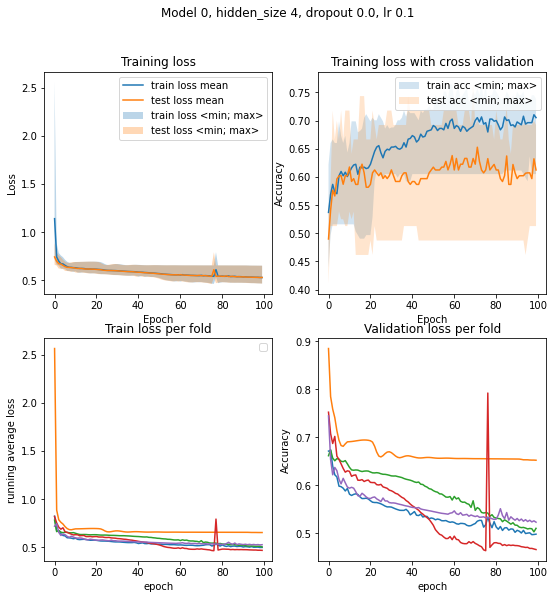

No handles with labels found to put in legend.


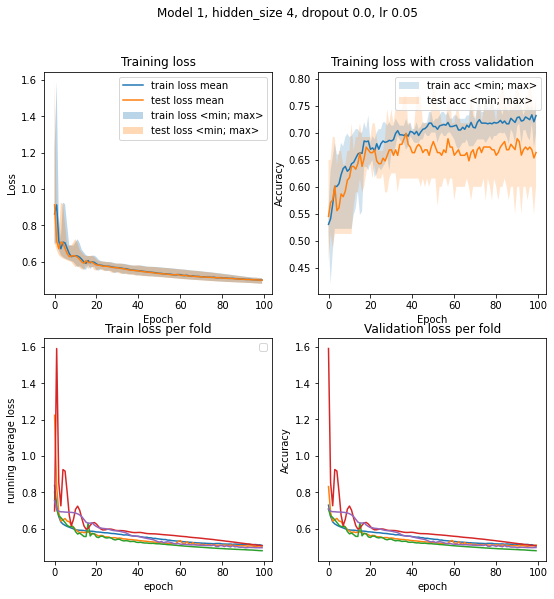

No handles with labels found to put in legend.


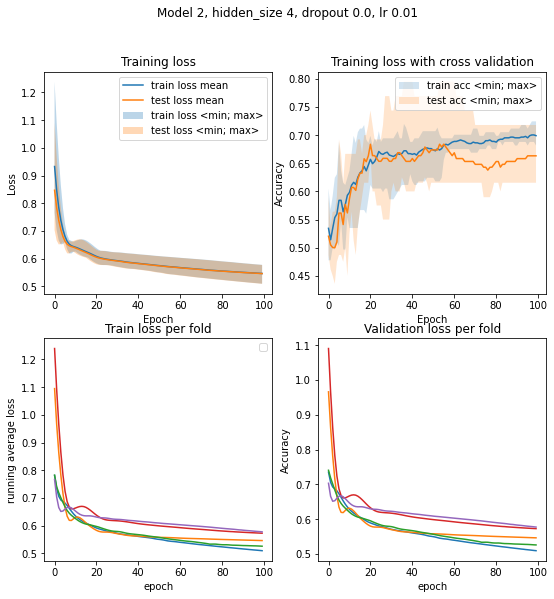

No handles with labels found to put in legend.


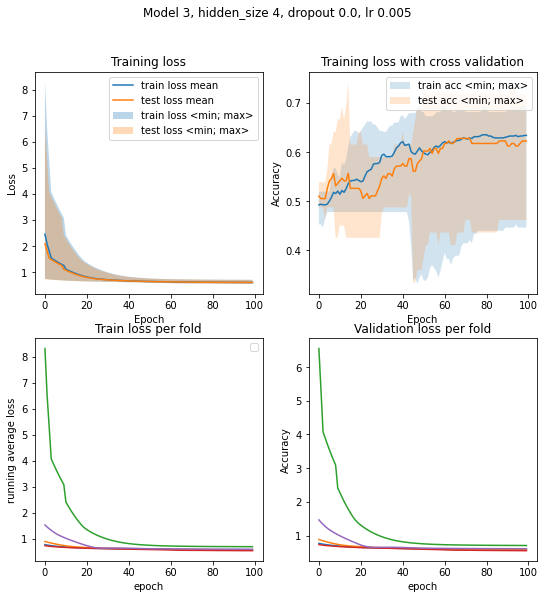

No handles with labels found to put in legend.


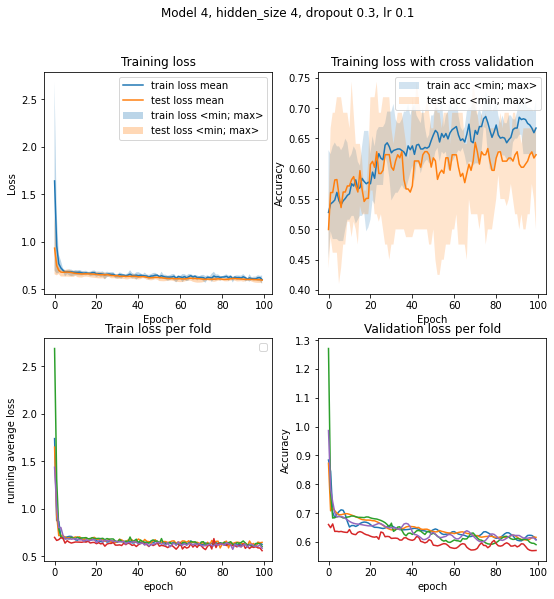

No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


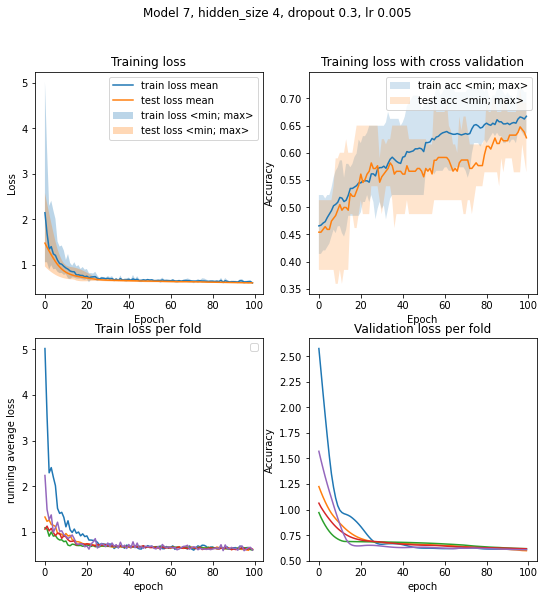

No handles with labels found to put in legend.


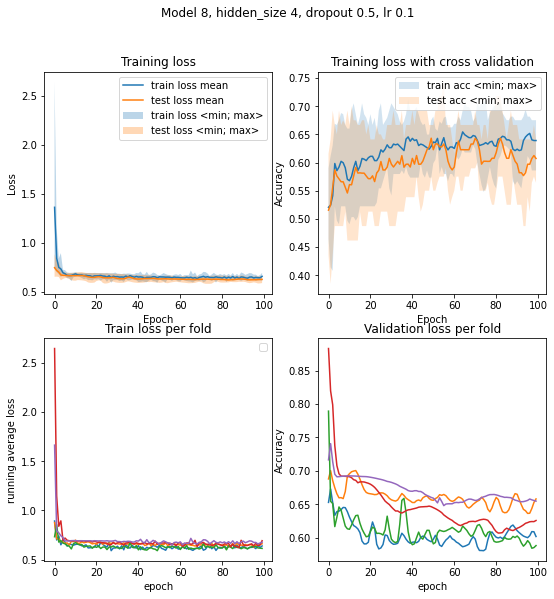

No handles with labels found to put in legend.


No handles with labels found to put in legend.


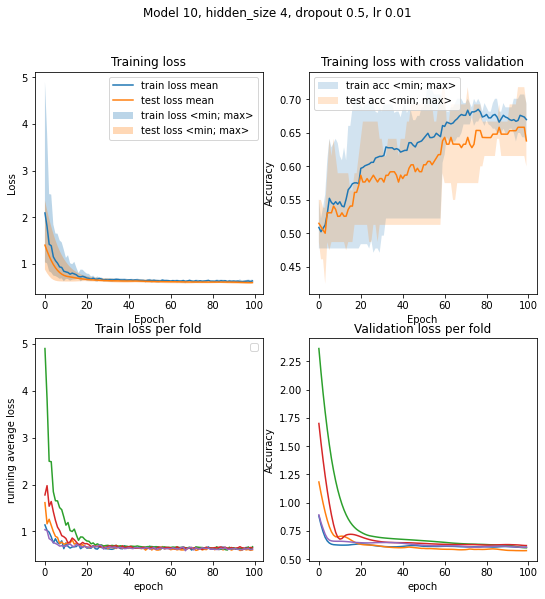

No handles with labels found to put in legend.


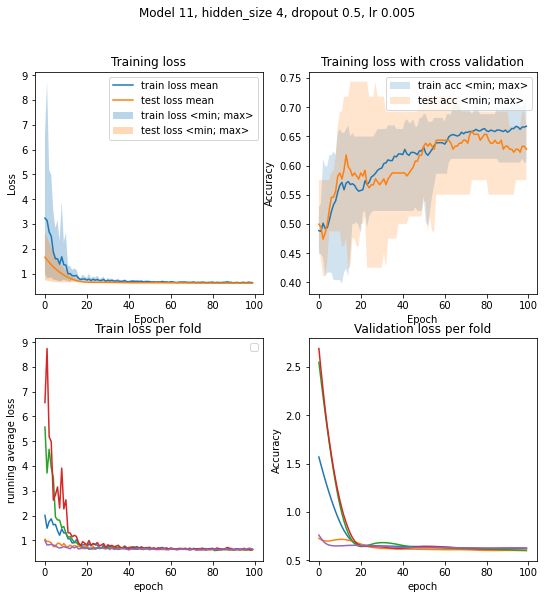

No handles with labels found to put in legend.


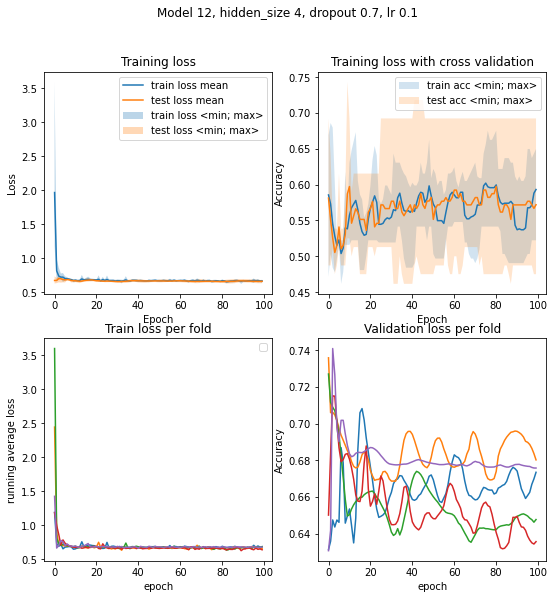

No handles with labels found to put in legend.


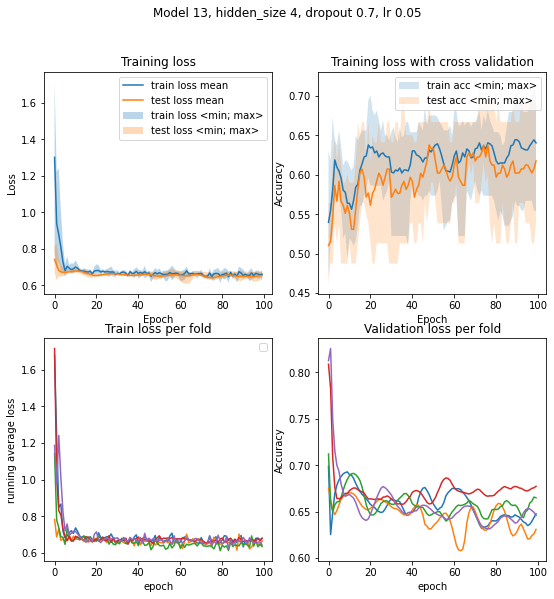

No handles with labels found to put in legend.


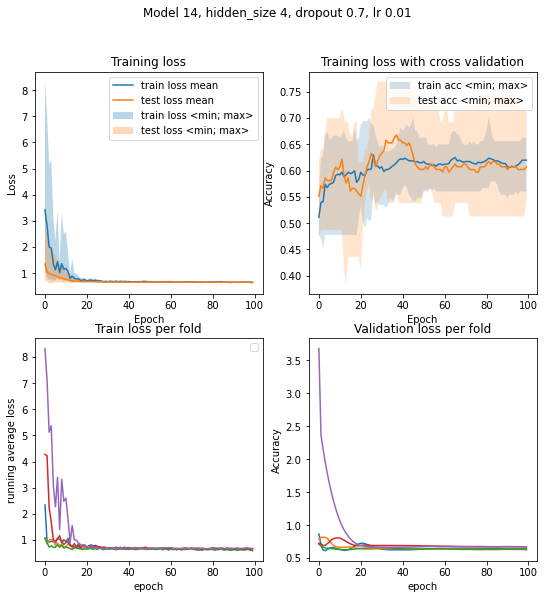

No handles with labels found to put in legend.


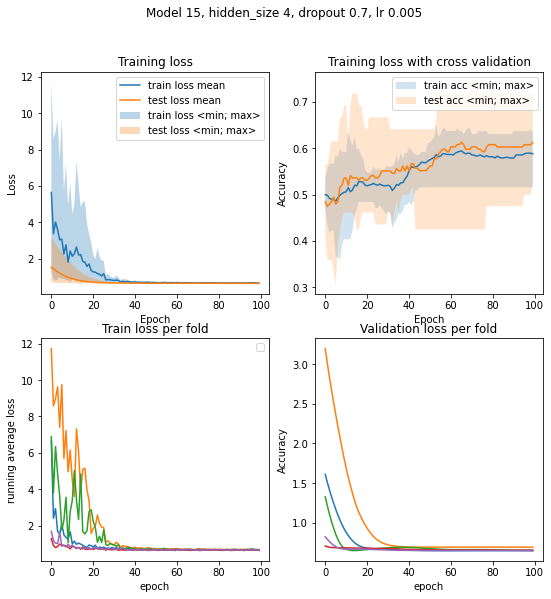

No handles with labels found to put in legend.


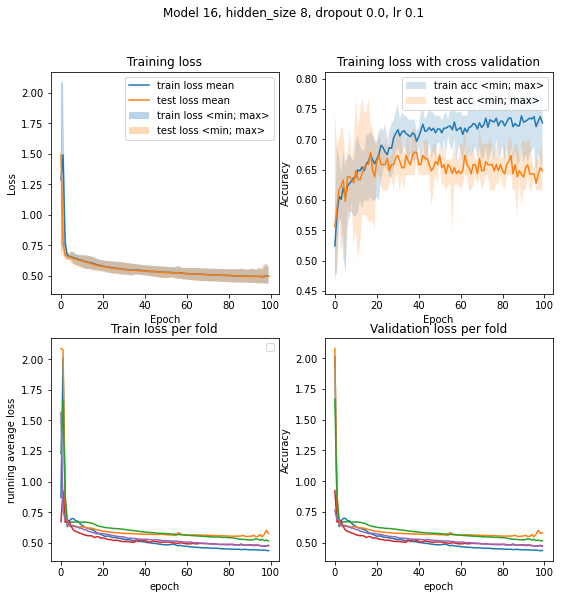

No handles with labels found to put in legend.


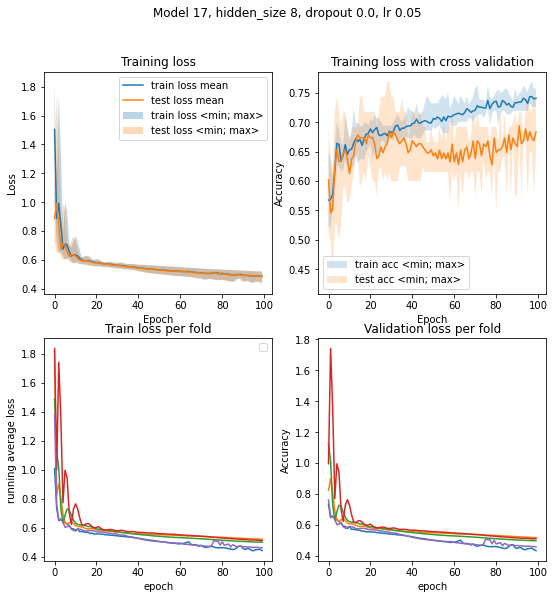

No handles with labels found to put in legend.


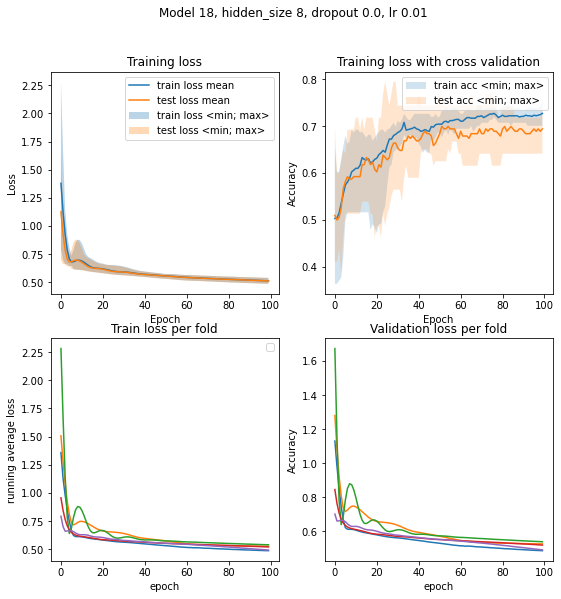

No handles with labels found to put in legend.


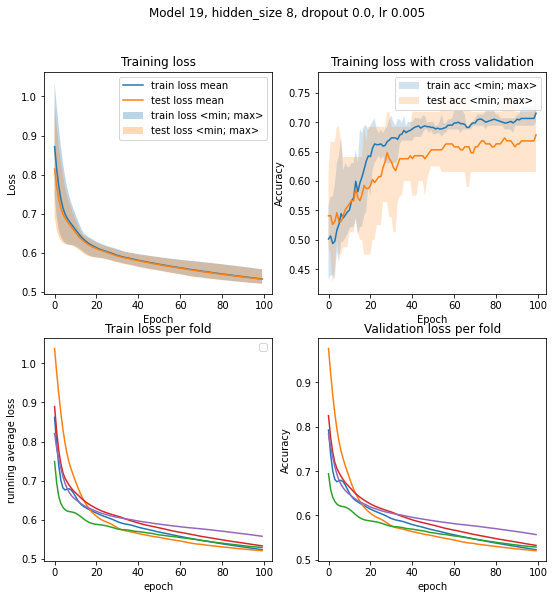

No handles with labels found to put in legend.


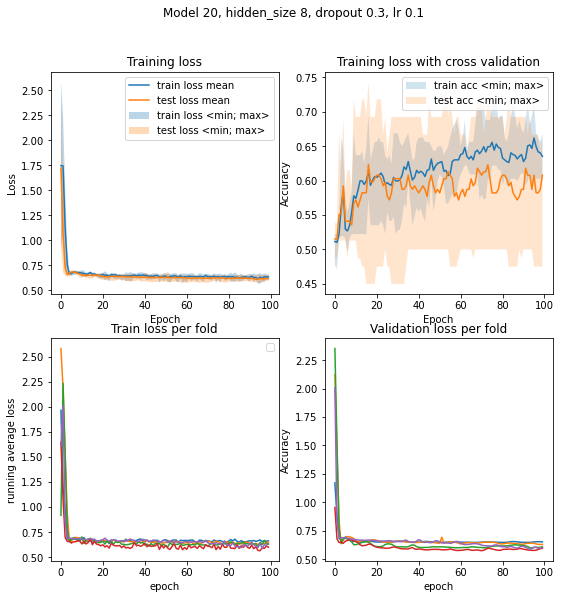

No handles with labels found to put in legend.


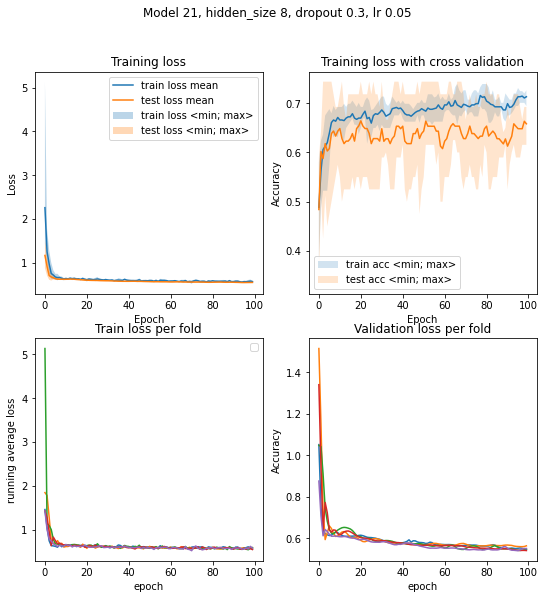

No handles with labels found to put in legend.


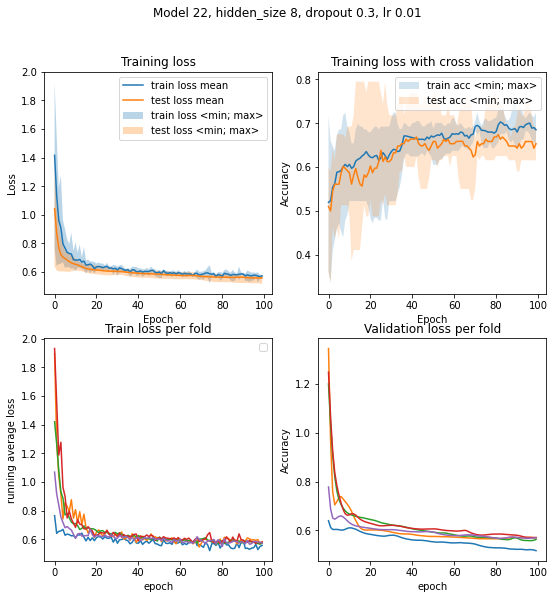

No handles with labels found to put in legend.


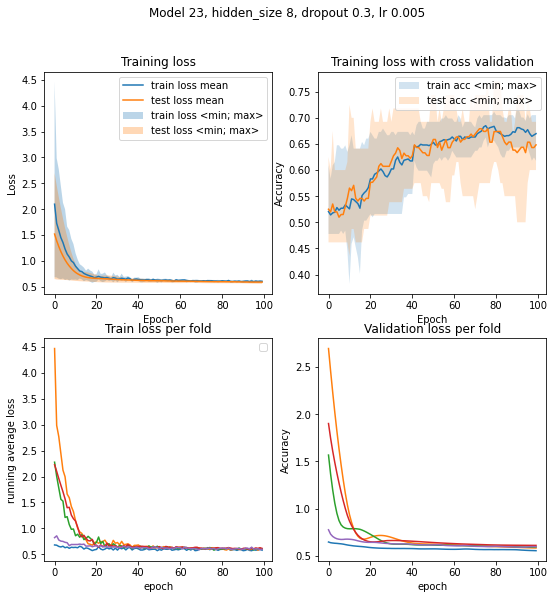

No handles with labels found to put in legend.


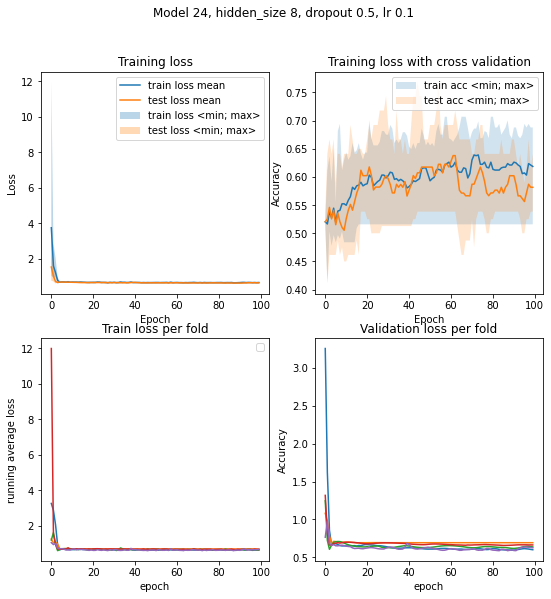

No handles with labels found to put in legend.


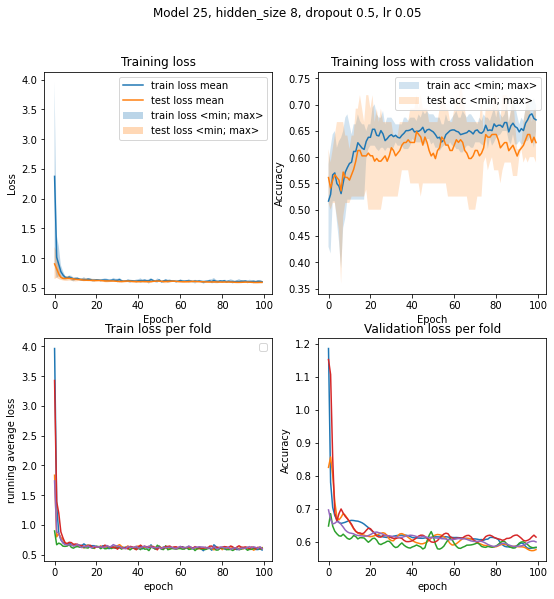

No handles with labels found to put in legend.


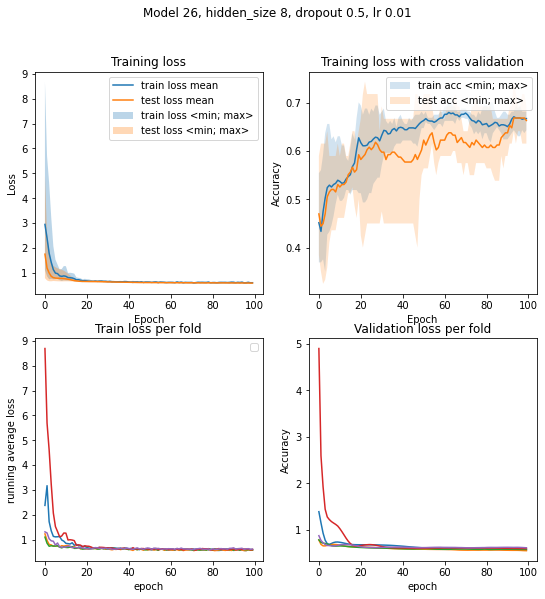

No handles with labels found to put in legend.


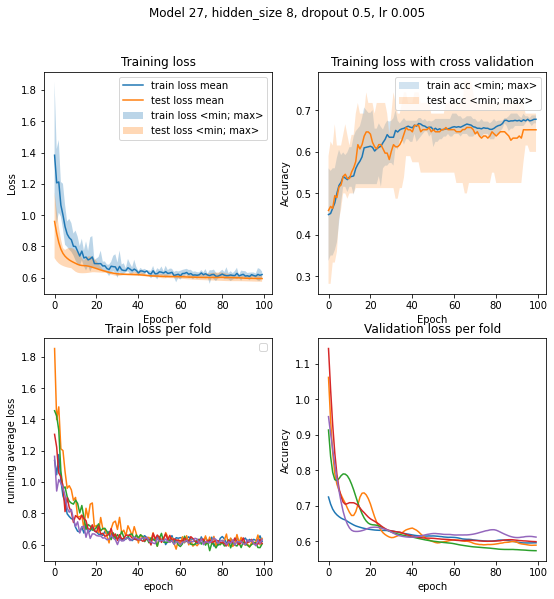

No handles with labels found to put in legend.


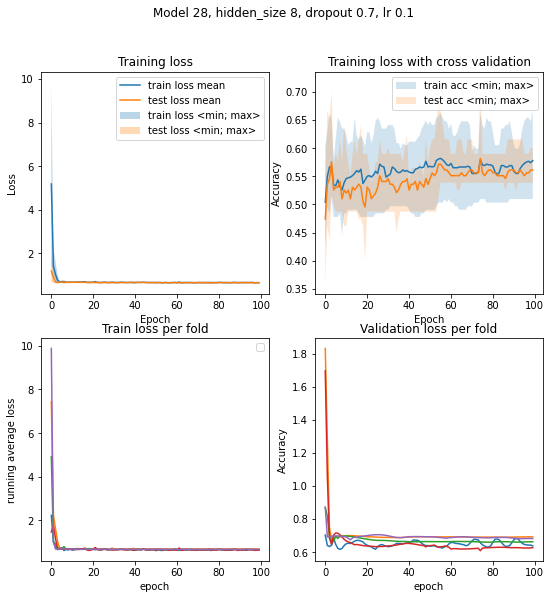

No handles with labels found to put in legend.


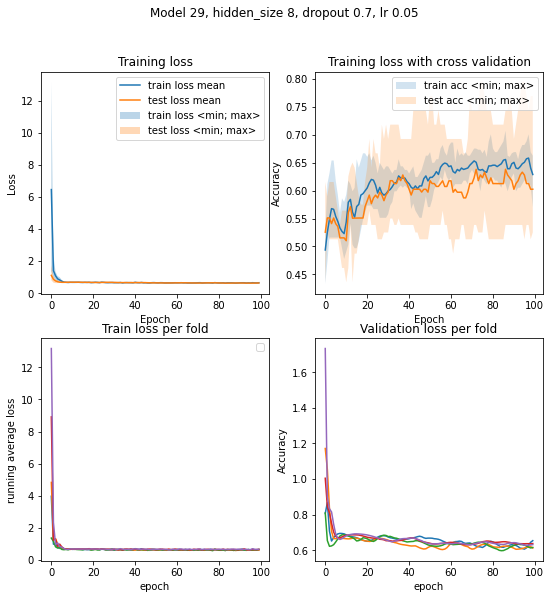

No handles with labels found to put in legend.


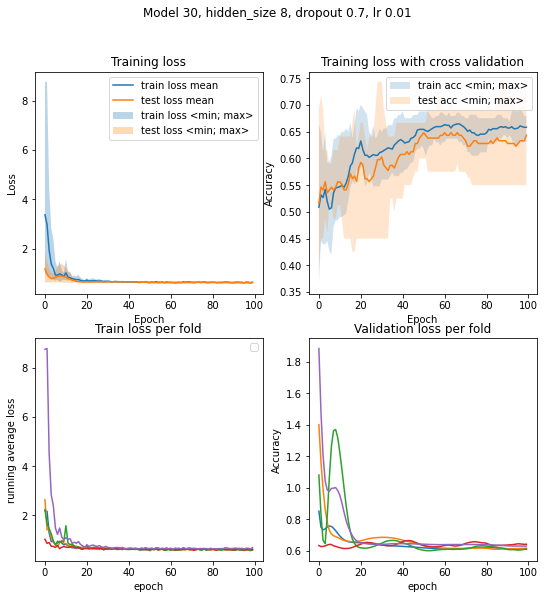

No handles with labels found to put in legend.


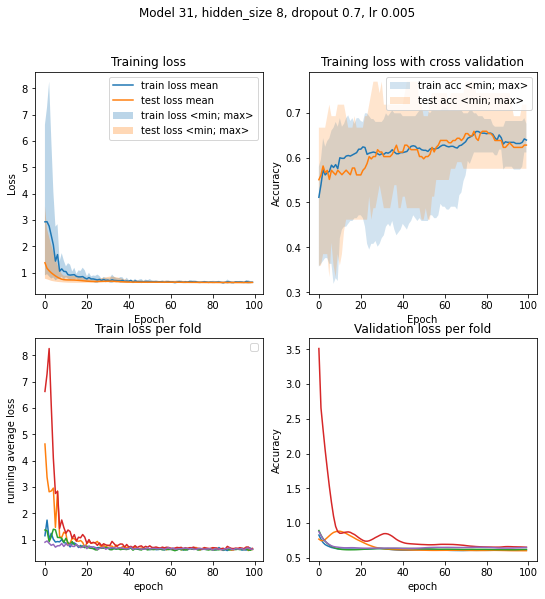

No handles with labels found to put in legend.


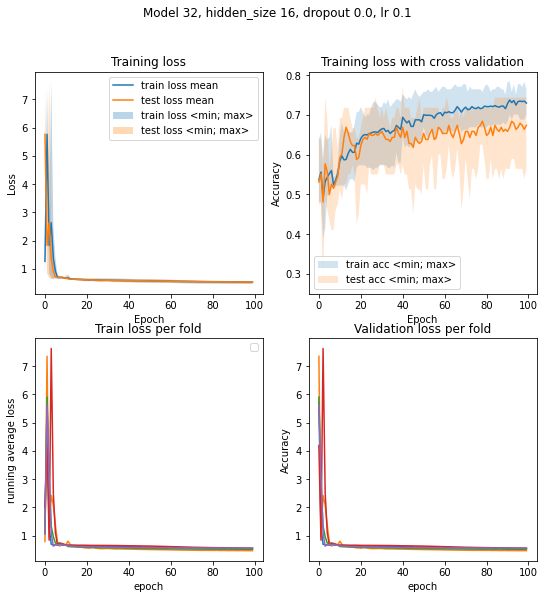

No handles with labels found to put in legend.


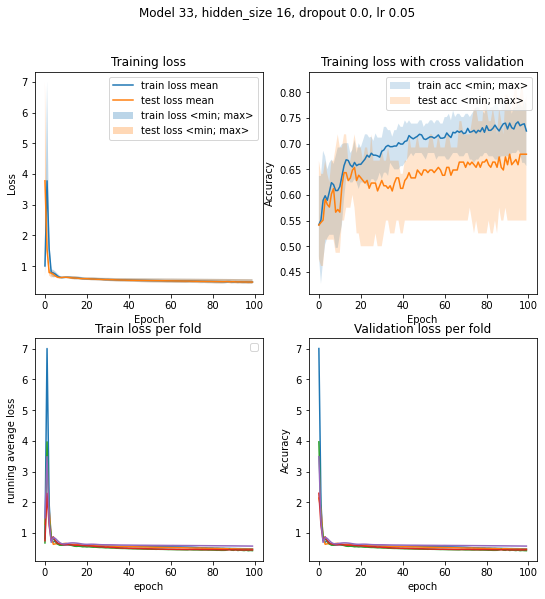

No handles with labels found to put in legend.


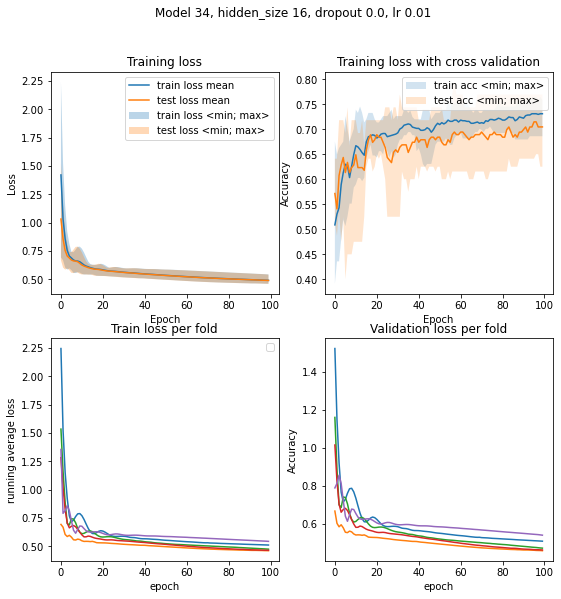

No handles with labels found to put in legend.


No handles with labels found to put in legend.


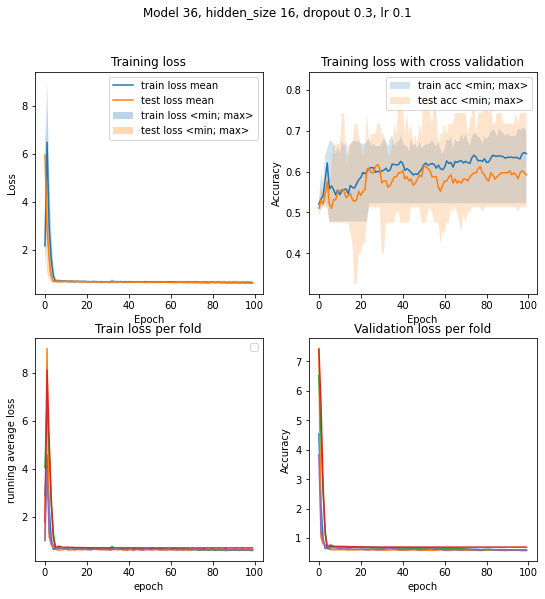

No handles with labels found to put in legend.


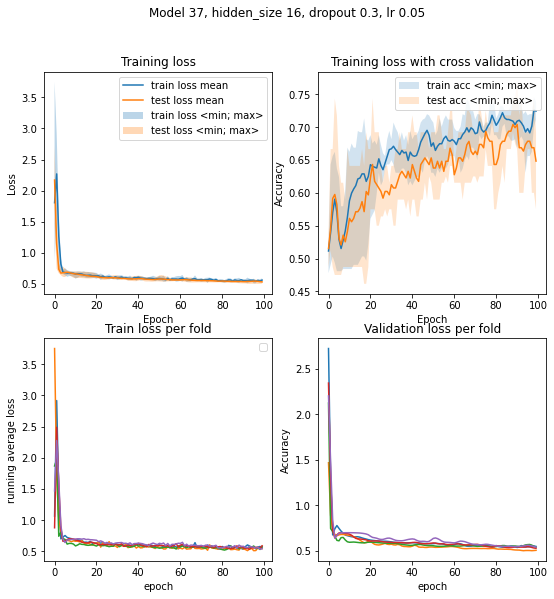

No handles with labels found to put in legend.


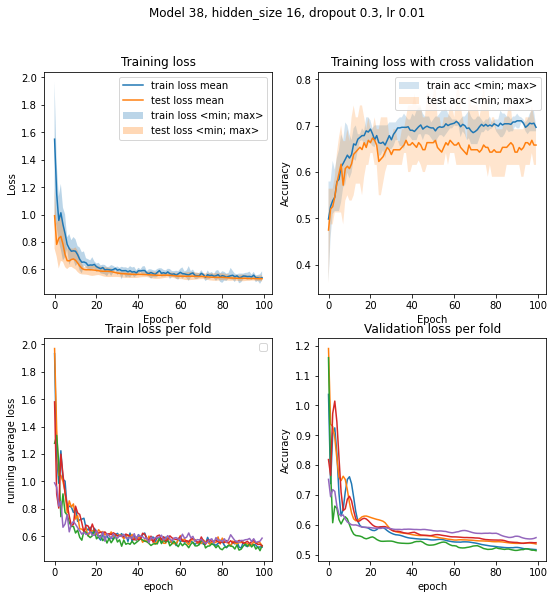

No handles with labels found to put in legend.


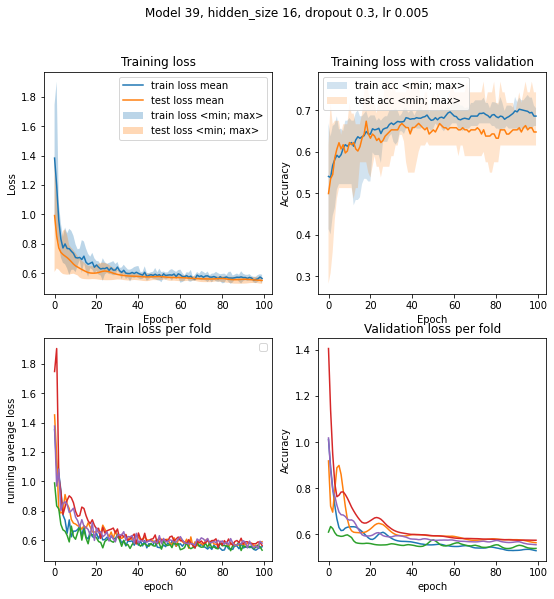

No handles with labels found to put in legend.


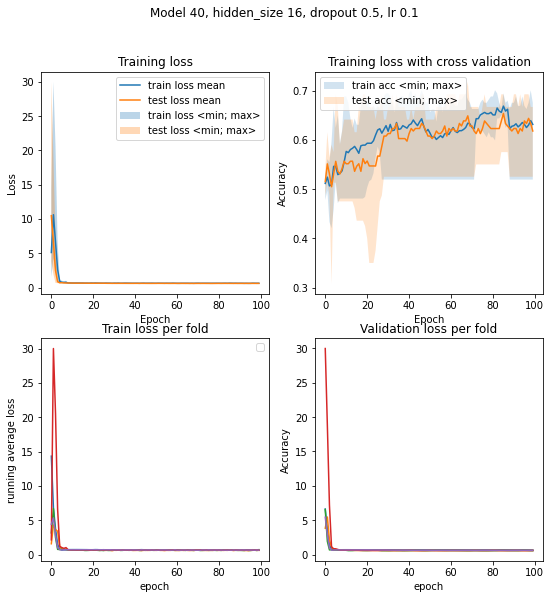

No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


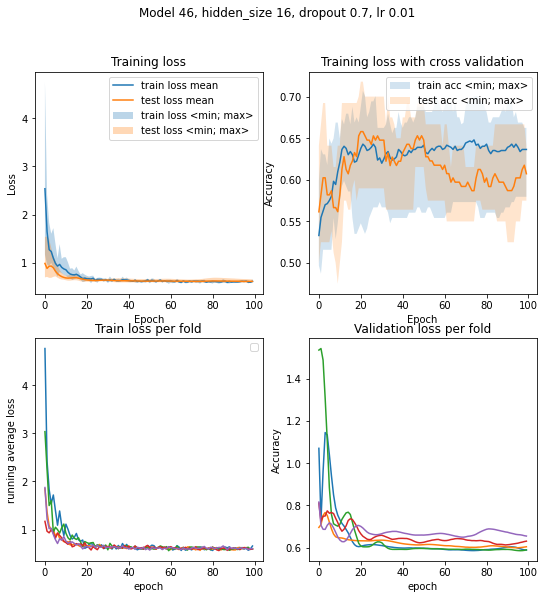

No handles with labels found to put in legend.


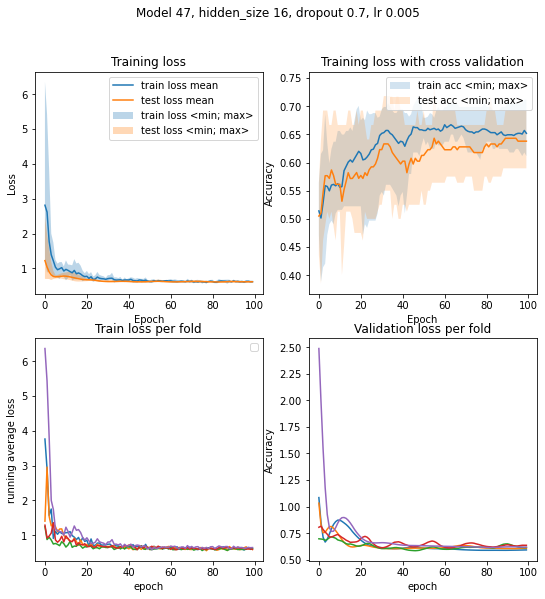

No handles with labels found to put in legend.


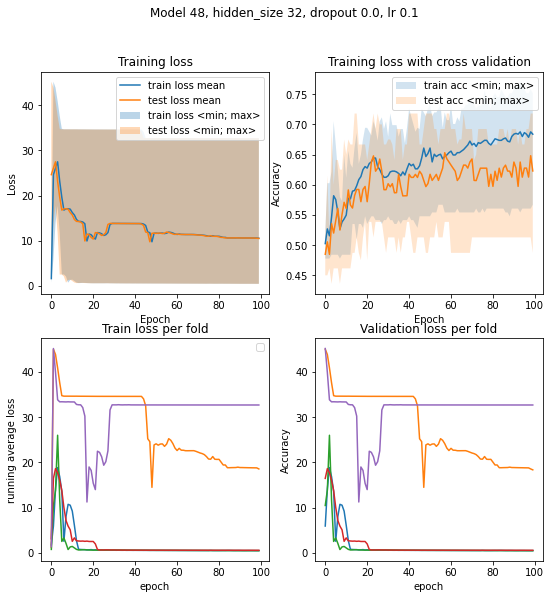

No handles with labels found to put in legend.


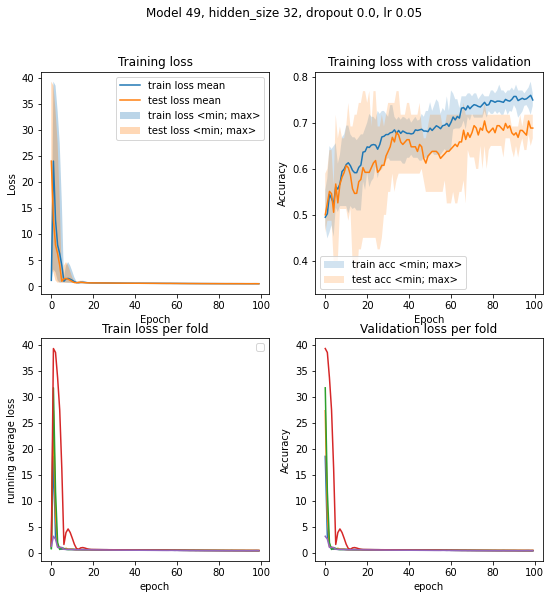

No handles with labels found to put in legend.


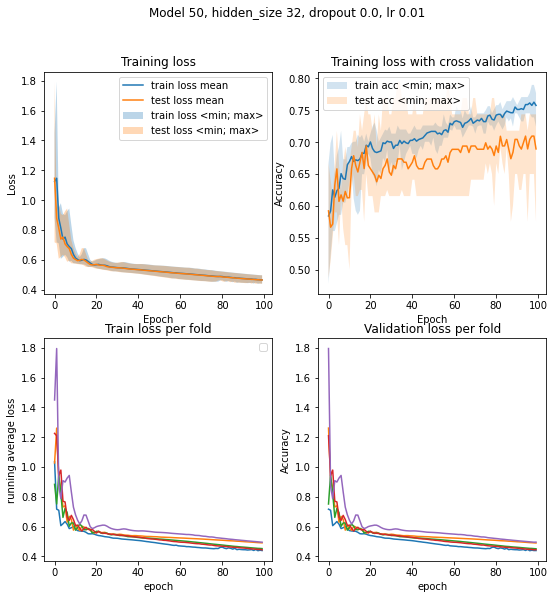

No handles with labels found to put in legend.


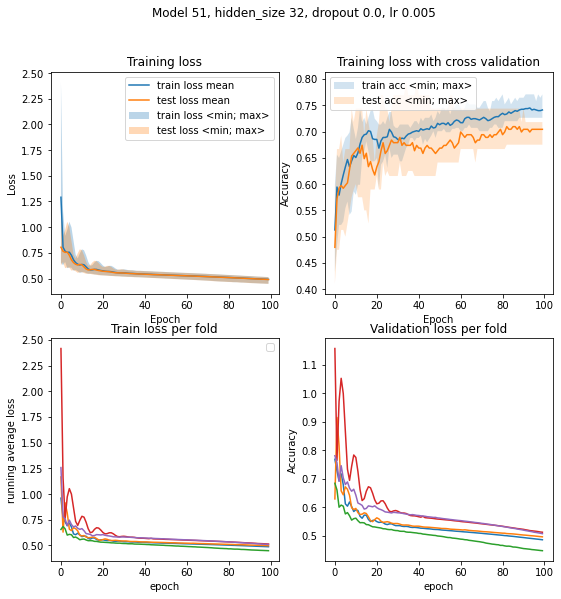

No handles with labels found to put in legend.


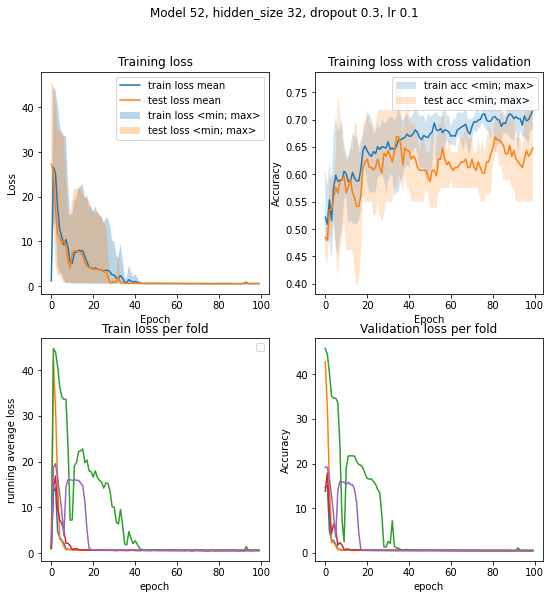

No handles with labels found to put in legend.


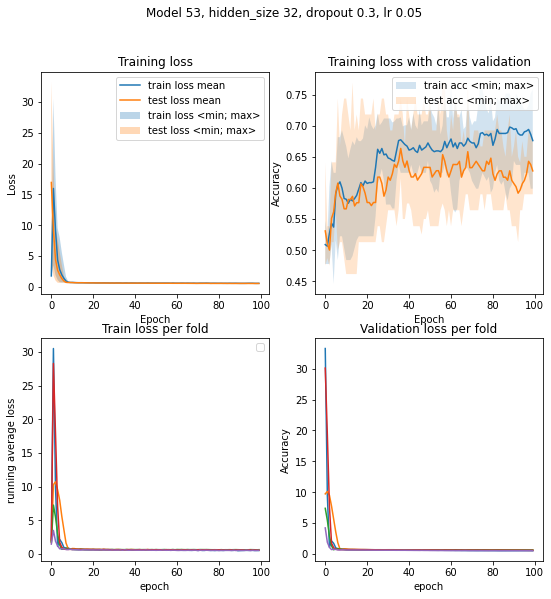

No handles with labels found to put in legend.


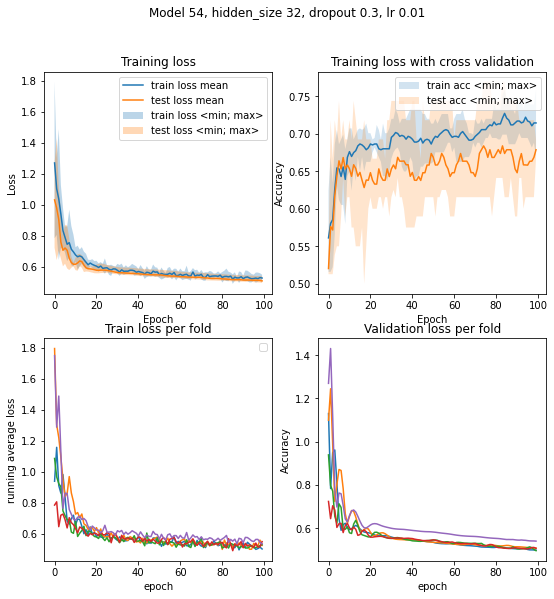

No handles with labels found to put in legend.


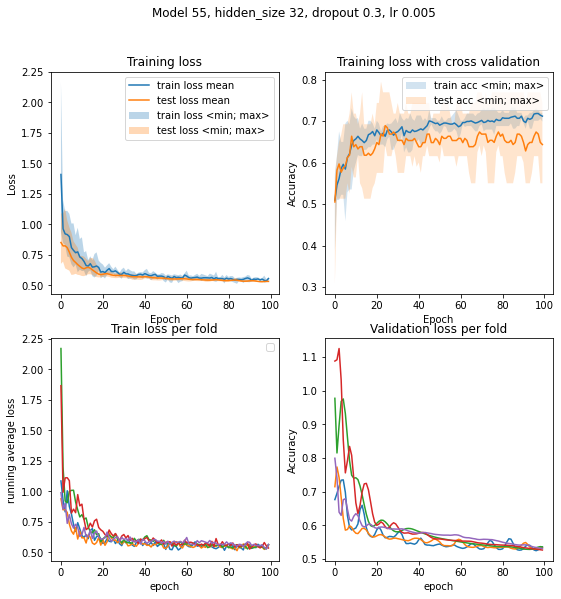

No handles with labels found to put in legend.


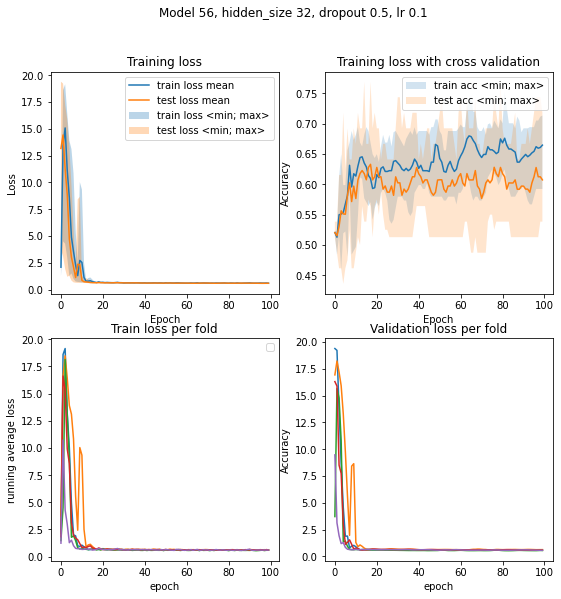

No handles with labels found to put in legend.


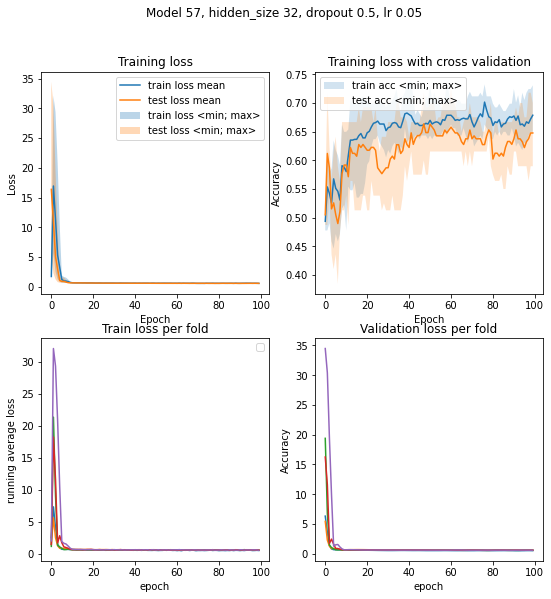

No handles with labels found to put in legend.


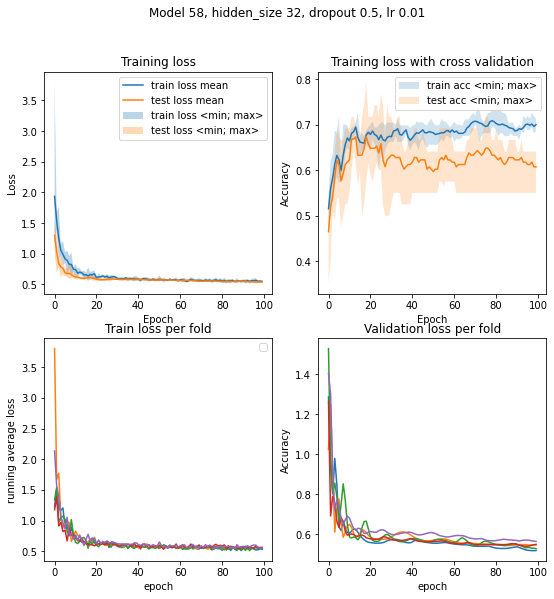

No handles with labels found to put in legend.


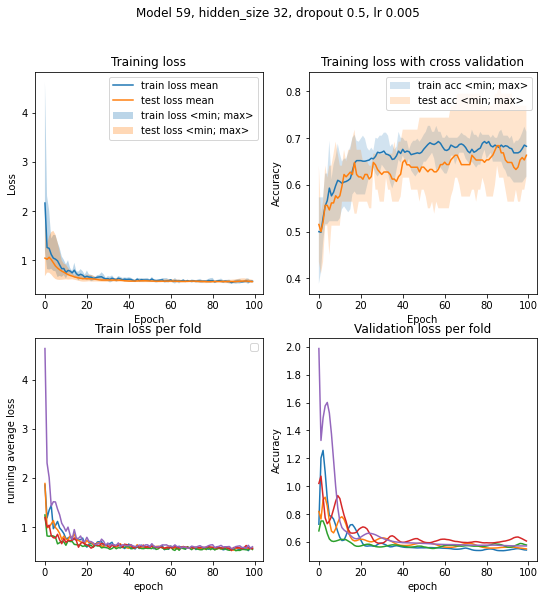

No handles with labels found to put in legend.


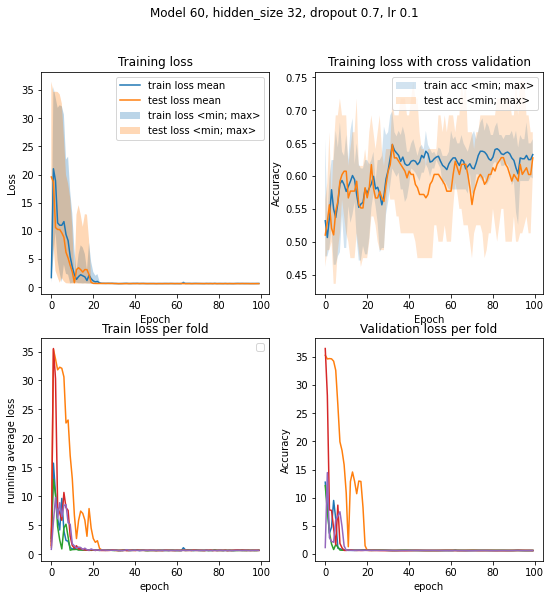

No handles with labels found to put in legend.


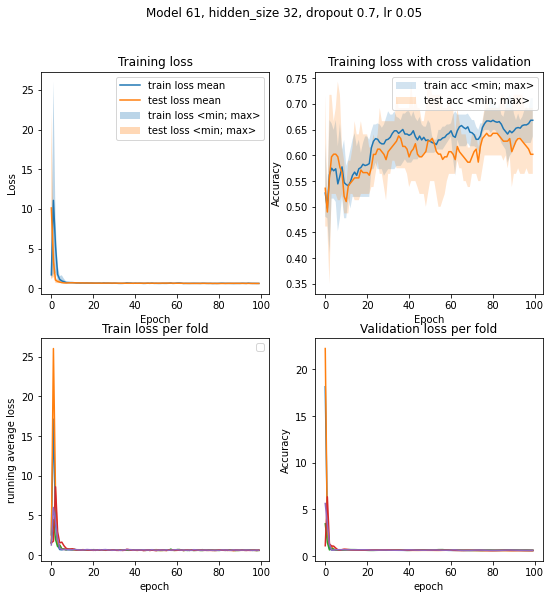

No handles with labels found to put in legend.


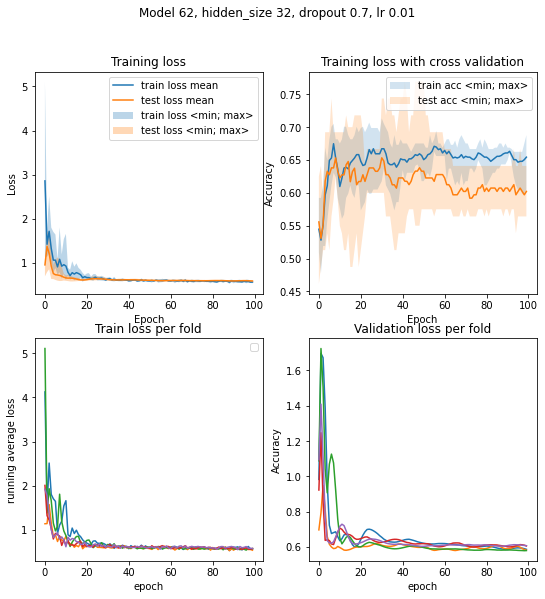

No handles with labels found to put in legend.


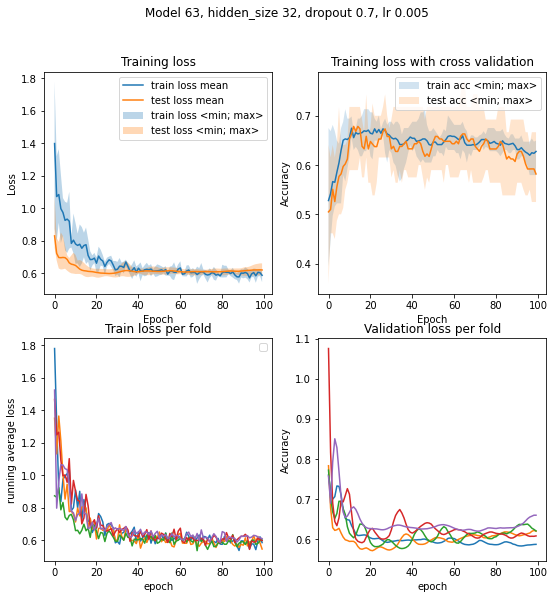

No handles with labels found to put in legend.


No handles with labels found to put in legend.


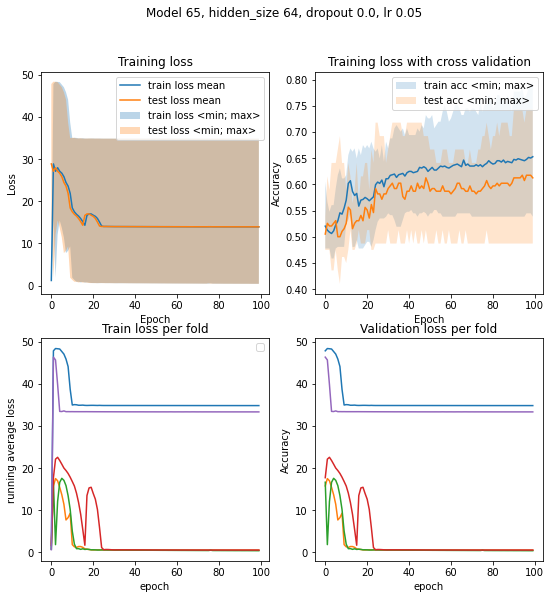

No handles with labels found to put in legend.


No handles with labels found to put in legend.


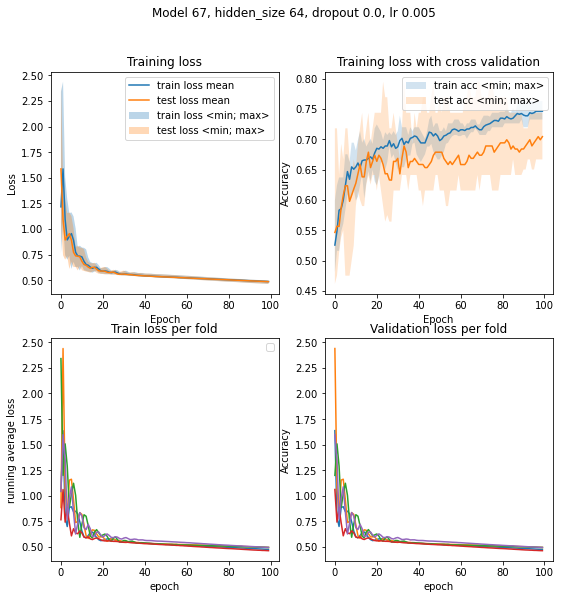

No handles with labels found to put in legend.


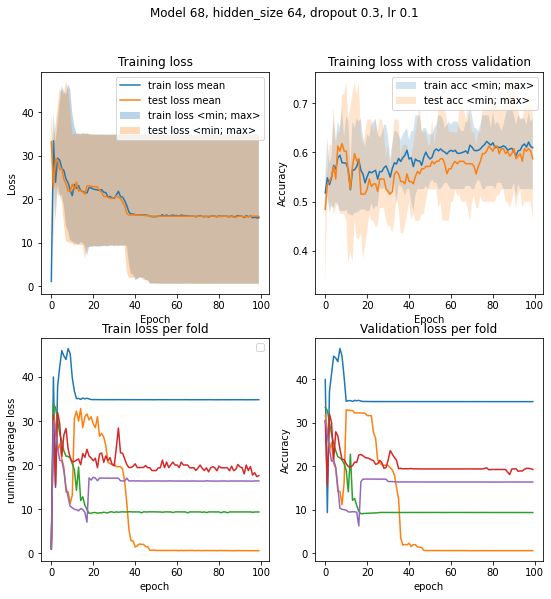

No handles with labels found to put in legend.


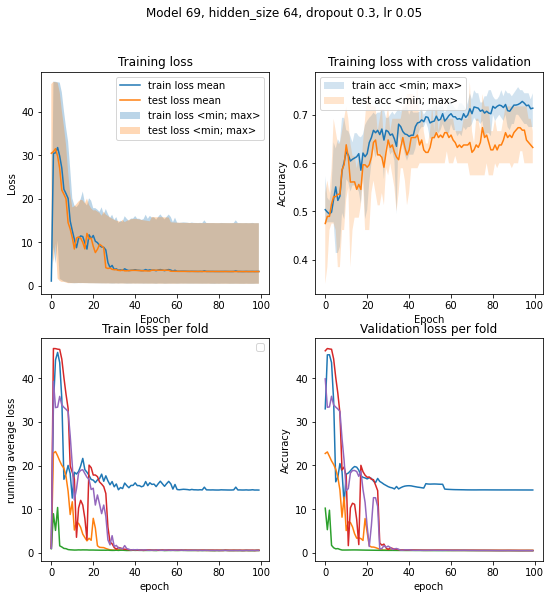

No handles with labels found to put in legend.


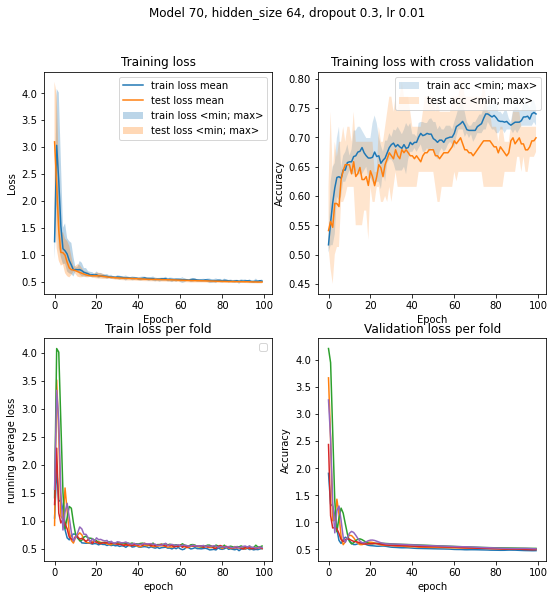

No handles with labels found to put in legend.


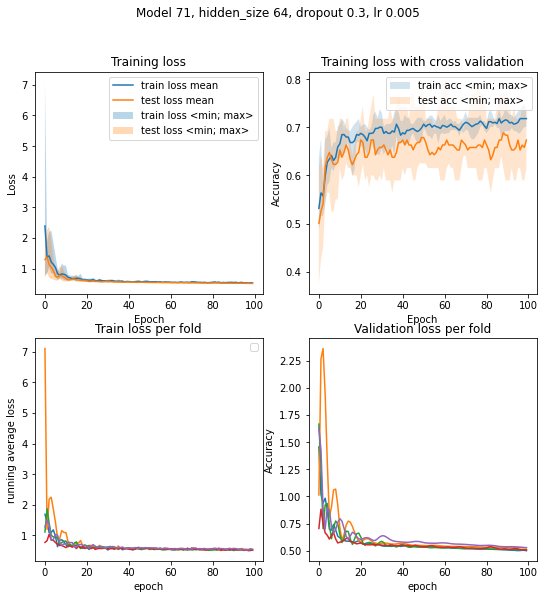

No handles with labels found to put in legend.


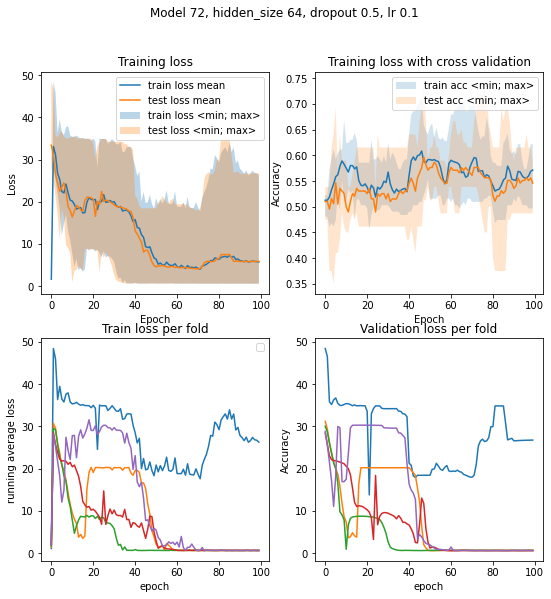

No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


No handles with labels found to put in legend.


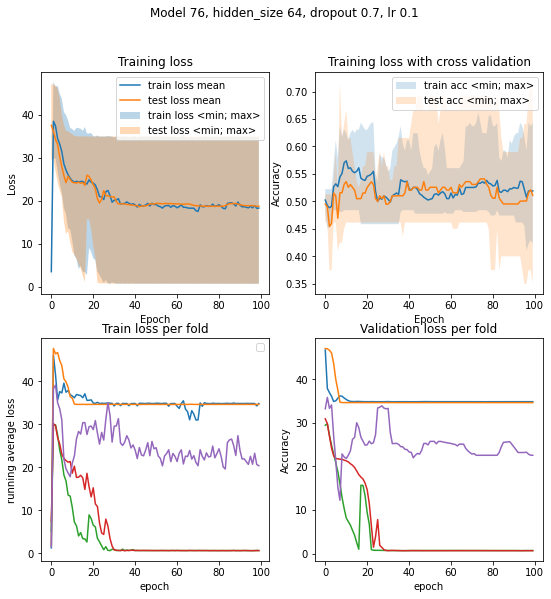

No handles with labels found to put in legend.


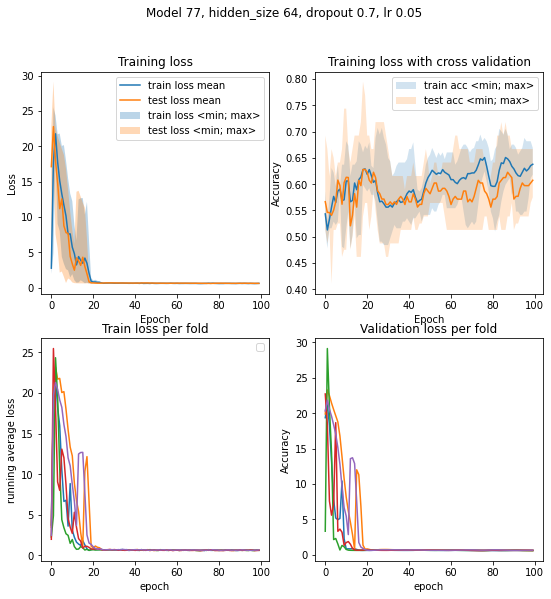

No handles with labels found to put in legend.


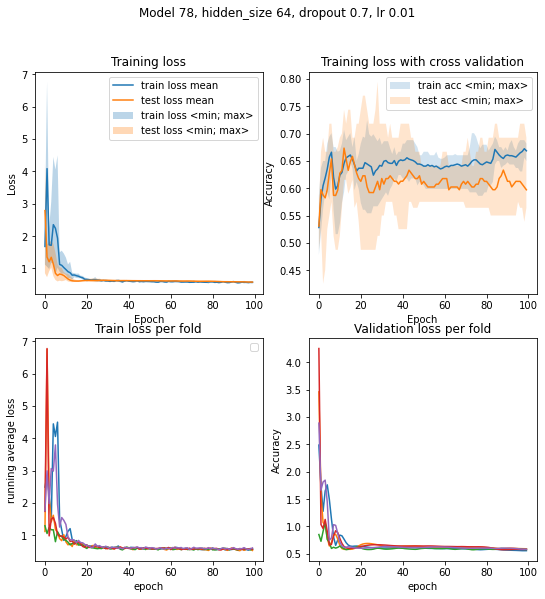

No handles with labels found to put in legend.


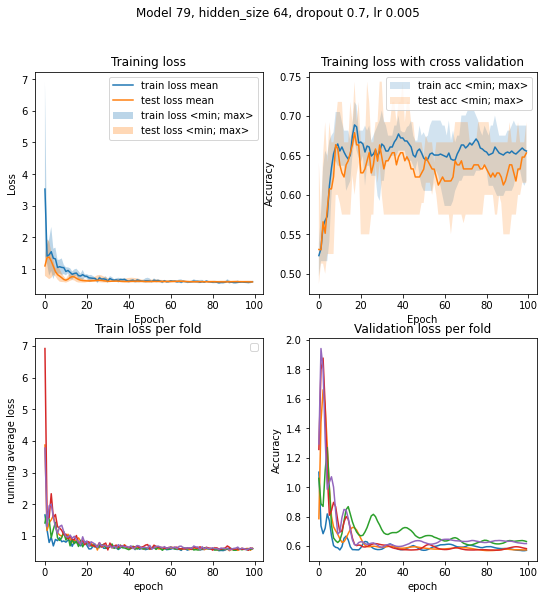

In [11]:
for i, foldperf in enumerate(results):
    train_loss = np.vstack([foldperf[fold]['train_loss'] for fold in foldperf])
    test_loss = np.vstack([foldperf[fold]['test_loss'] for fold in foldperf])
    train_acc = np.vstack([foldperf[fold]['train_acc'] for fold in foldperf])
    test_acc = np.vstack([foldperf[fold]['test_acc'] for fold in foldperf])
    
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(9, 9))
    fig.suptitle(f'Model {i}, hidden_size {model_params[i][0]}, dropout {model_params[i][1]}, lr {model_params[i][2]}')
    ax1.set_xlabel("Epoch")
    ax1.set_ylabel("Loss")
    ax1.title.set_text('Training loss')
    ax1.fill_between(range(num_epochs), train_loss.min(0), train_loss.max(0), alpha=0.3, label="train loss <min; max>")
    ax1.fill_between(range(num_epochs), test_loss.min(0), test_loss.max(0), alpha=0.3, label="test loss <min; max>")

    ax1.plot(range(num_epochs), train_loss.mean(0), label='train loss mean')
    ax1.plot(range(num_epochs), test_loss.mean(0), label='test loss mean')
    ax1.legend()
    
    
    
    ax2.title.set_text("Training loss with cross validation")
    ax2.set_xlabel("Epoch")
    ax2.set_ylabel("Accuracy")
    ax2.fill_between(range(num_epochs), train_acc.min(0), train_acc.max(0), alpha=0.2, label="train acc <min; max>")
    ax2.fill_between(range(num_epochs), test_acc.min(0), test_acc.max(0), alpha=0.2, label="test acc <min; max>")

    ax2.plot(range(num_epochs), train_acc.mean(0))

    ax2.plot(range(num_epochs), test_acc.mean(0))
    ax2.legend()

    
    
    ax3.title.set_text('Train loss per fold')
    for l in train_loss:
        ax3.plot(l)
#     for l in train_loss:
#         ax3.plot(l, 'b-', alpha=0.5)
#     for l in test_loss:
#         ax3.plot(l, 'r-', alpha=0.5)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax3.set_xlabel('Epoch')
    ax3.set_ylabel('Loss')

    ax3.legend()
    
    ax4.title.set_text('Validation loss per fold')
    for l in test_loss:
        ax4.plot(l)
#     ax3.plot(np.convolve(train_loss.mean(0), np.ones(20)/20, mode='valid'), label='train loss')
#     ax3.plot(np.convolve(test_loss.mean(0), np.ones(20)/20, mode='valid'), label='test loss')
    ax4.set_ylabel('Accuracy')
    ax4.set_xlabel('Epoch')
    plt.show()


In [12]:
accs = []
for i, foldperf in enumerate(results):
    accs.append(np.vstack([foldperf[fold]['test_acc'][-1] for fold in foldperf]).mean(0))
best_params = model_params[np.asarray(accs).argmax()]


In [15]:
hidden_size, dropout, lr = best_params
model = RGCN(in_feature_size, hidden_size, dropout, num_edge_types)

train_loader = GraphDataLoader(train_graphs, batch_size=1000)
# test_loader = GraphDataLoader(train_graphs, batch_size=1000)

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
history = {'train_loss': [], 'test_loss': [],'train_acc':[],'test_acc':[]}
train_loss = []
train_acc = []

for epoch in range(num_epochs):
    loss = train(model,train_loader,optimizer)
    acc = evaluate(model, train_loader)
    train_loss.append(loss)
    train_acc.append(acc)


<Figure size 432x288 with 0 Axes>

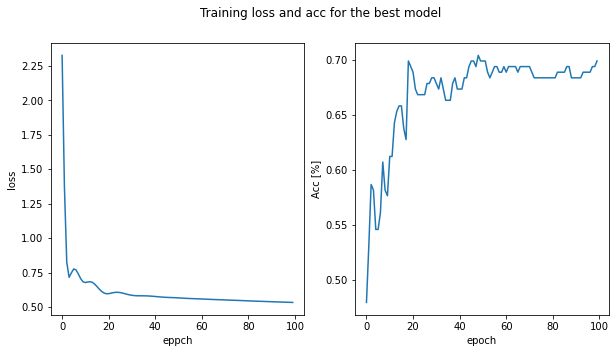

In [16]:
plt.figure()
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(10, 5))
plt.suptitle('Training loss and acc for the best model')
ax1.set_xlabel('eppch')
ax1.set_ylabel('loss')
ax1.plot(train_loss)

ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc [%]')
ax2.plot(train_acc)

plt.show()

In [17]:
###### test_loader = GraphDataLoader(test_graphs, batch_size=1000)

print('best params: hidden size {}, dropout {}, Adam learning rate{}'.format(*best_params))
acc = evaluate(model, test_loader)
print(f'Model test acc is {acc*100}%')

best params: hidden size 16, dropout 0.0, Adam learning rate0.01
Model test acc is 76.92307692307693%
